# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic
from matplotlib_scalebar.scalebar import ScaleBar

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *
# pd.set_option('display.max_rows', None)

# ray.init(
#     ignore_reinit_error=True,
#     logging_level=logging.ERROR,
# )


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/seuss/anaconda3/e

In [2]:
# Run the 070921 Preprocessing with native 16 ms time and no downsample. Shifter network, then save time, eye/head position and video into .mat files.

In [2]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['free_move']   = True
args['date_ani']    = dates_all[0]
args['NoL1']        = False
args['NoL2']        = False
args['reg_lap']     = False
args['do_shuffle']  = False
args['use_spdpup']  = False
args['only_spdpup'] = False
args['complex']     = False
args['crop_input']  = True
args['Nepochs'] = 10000

params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(params['model_type'],int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, comples: False


# Load Paper Data

In [3]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'RevisionFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"] # Magenta to Blue
mod_clrs = ["#B541FF","#06d6a0","#118ab2","#ef476f","#073b4c"] #["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
# mod_clrs = ["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
fontsize=10
mod_titles = ['pos','vis','add','mul','HF']

import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                    })

In [3]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF,ax_lims_all = [],[],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    ax_lims_all.append(ax_ylims)
    model_move_FM.append(model_move)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move']   = False
    args['use_spdpup']  = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)
ax_lims_all = np.vstack(ax_lims_all)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)

ModelList_all


Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)


array([[PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel0/version_0/GLM_Pytorch_Mot_dt050_T05_MovModel0_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel2/version_0/GLM_Pytorch_Add_dt050_T05_MovModel2_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel3/version_0/GLM_Pytorch_Mul_dt050_T05_MovModel3_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/hf1_wn/CropInputs/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/101521/J559NC/fm1/CropInputs

In [4]:
sf=4
# params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            if params['complex']:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            else:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_cc'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


# Figure 2

## No Shifter RFs

In [ ]:
params['save_dir']

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/fm1')

In [6]:

Kfold = 0
args['free_move']=True
# mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
# dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_NoSh,NCells_all,bad_cells_all,test_nsp_all = [],[],[],[]
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('VisNoShifter' in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    # ModelList = np.array(sorted(list(date_ani_dir.rglob(mod_name+'.h5'))))
    ModelList_NoSh.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    NCells_all.append(data['test_nsp'].shape[-1])
ModelList_NoSh = np.stack(ModelList_NoSh)

ModelList_NoSh

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)


array([[PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_VisNoShifter_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/101521/J559NC/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_VisNoShifter_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/102821/J570LT/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_VisNoShifter_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/110421/J569LT/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_VisNoShifter_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')]],
      dtype=object)

In [7]:
NoSh_titles=['VisNoSh']
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
NoSh_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    NoSh_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    NoSh_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    # NoSh_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_NoSh[da]):
        GLM_Data = ioh5.load(fmod)
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # NoSh_data[date_ani][NoSh_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(NoSh_data[date_ani][NoSh_titles[ModelRun]+'_pred_smooth'][:,celln],NoSh_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(NoSh_data[date_ani]['actual_smooth'].shape[1])])
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(NoSh_data[date_ani][NoSh_titles[ModelRun]+'_pred_smooth'][:,celln],NoSh_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(NoSh_data[date_ani]['actual_smooth'].shape[1])])
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
        RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
        RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
        for celln in range(RF_all.shape[0]):
            for t in range(RF_all.shape[1]):
                RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_rf_up'] = RF_all_up
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_rf_all'] = RF_all

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
fontsize=24
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [10]:
GLM_Data['Cell_NN.0.weight'].shape

(108, 6000)

In [7]:

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


## Full Figure CC Version

In [8]:
SimRF_file = '/home/seuss/Research/SensoryMotorPred_Data/data2/121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format('withL1',int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
SimRFfit_file = '/home/seuss/Research/SensoryMotorPred_Data/data2/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
SimFit_Data = ioh5.load(SimRFfit_file)
SimRF_Data = ioh5.load(SimRF_file)
RF_SimFit = SimFit_Data['Cell_NN.0.weight'].reshape((SimFit_Data['Cell_NN.0.weight'].shape[0],1,)+(30,40))
SimFit_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=SimFit_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_Data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])

Sim_cc = np.array([(np.corrcoef(SimRF_Data['RF_actual'][celln].flatten(),RF_SimFit[celln,0].flatten())[0, 1]) for celln in range(Sim_act_smooth.shape[0])])

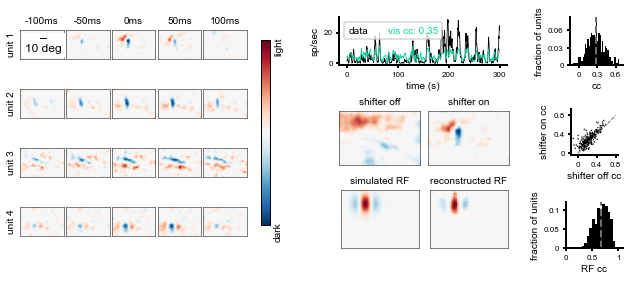

In [101]:
##### CC instead of r2 #####

vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_VisNoSh = np.hstack([NoSh_data[date_ani2[da]]['VisNoSh_cc_test'] for da in range(len(dates_all))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))
fontsize=10
fig1 = plt.figure(constrained_layout=False, figsize=(10.8,4.25))
gs0 = fig1.add_gridspec(nrows=3, ncols=8, wspace=.8, hspace=.9)
lag_ls = [-100,-50,0,50,100]
lag_list = [0,1,2,3,4]
########## Fig 2B ########## 
da=0
cells = [22,34,42,101] #np.arange(18)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=len(cells),ncols=len(lag_list), subplot_spec=gs0[:,:4], wspace=.05, hspace=.08)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(len(cells)) for m in range(len(lag_list))]).reshape(len(cells),len(lag_list))
params['nt_glm_lag']=5
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs1[0,m].set_title('{}ms'.format(lag_ls[m]),fontsize=fontsize)

    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)
    
scale1 = ScaleBar(dx=.5, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} deg')
axs1[0,0].add_artist(scale1)

cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2C ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,4:],wspace=1.2,hspace=.2)
axs2 = np.array([fig1.add_subplot(gs02[0,:2]), fig1.add_subplot(gs02[0,2])])

celln = 42
da = 0
modN = 1
ax = axs2[0]
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(300/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=.75,zorder=0,label='data')
ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=.75,
            label='{} cc: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=1)
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0,loc='upper left',ncol=2)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize-2)
plt.setp(ax.get_yticklabels(), fontsize=fontsize-2)
# scale1 = ScaleBar(dx=1, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} s')
# scale2 = ScaleBar(dx=1, width_fraction=.01,rotation="vertical",location='center left',scale_formatter=lambda value, unit: f'{value} sp/s')
# ax.add_artist(scale1)
# ax.add_artist(scale2)

ax = axs2[1]
hbins = .02
sta_titles = ['shifter Off','shifter On']
NoShift_clrs = ["#050505", "#C41508"]
lim0 = -.1
lim1 = .7
dlim = .2
xlab = 'cc'
count,edges = np.histogram(r2_all[1],bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2_all[1]),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(r2_all[1]),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)


########## Fig 2D ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1:,4:],wspace=1,hspace=.5)
gs02b = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs02[:2,:2],wspace=.1,hspace=.4)
axs3 = np.array([fig1.add_subplot(gs02b[0,0]), fig1.add_subplot(gs02b[0,1]),fig1.add_subplot(gs02b[1,0]), fig1.add_subplot(gs02b[1,1])]).reshape(2,2)
lag = 1
da = 0
cells = [22]
for n, cell in enumerate(cells):
    ax = axs3[0,n]
    crange2 = np.max(np.abs(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell]))
    im2 = ax.imshow(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter off',fontsize=fontsize)
    ax = axs3[0,n+1]
    crange2 = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][cell,2]))
    im2 = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][cell,2],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter on',fontsize=fontsize)

for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])



########## Fig 2E ########## 
gs02c = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs02[:,2:],wspace=.1,hspace=1)
axs3b = np.array([fig1.add_subplot(gs02c[0,0]), fig1.add_subplot(gs02c[1,0])])

ax = axs3b[0]
vis_th = r2_all[1] > .05
ax.scatter(r2_all[0][vis_th],r2_all[1][vis_th],s=2,c='k',edgecolors='none')
ax.plot(np.linspace(0, .8, 100), np.linspace(0, .8, 100),lw=1, c='#6D6E71',ls='--',zorder=1)
ax.set_xlabel(r'shifter off cc',fontsize=fontsize)
ax.set_ylabel(r'shifter on cc',fontsize=fontsize)
ax.set_xticks([0,.4,.8])
ax.set_xticklabels([0,.4,.8],fontsize=fontsize-2)
ax.set_yticks([0, .4, .8])
ax.set_yticklabels([0, .4, .8],fontsize=fontsize-2)
ax.axis('square')


########## Fig 2F ########## 
# gs03 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2,4:],wspace=1,hspace=.1)
# axs4 = np.array([fig1.add_subplot(gs03[n,m]) for n in range(1) for m in range(3)])

lag = 1
da = 0
cells = [0]
for n, cell in enumerate(cells):
    ax = axs3[1,n]
    crange2 = np.max(np.abs(SimRF_Data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_Data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('simulated RF', fontsize=fontsize)
    ax = axs3[1,n+1]
    crange1 = np.max(np.abs(RF_SimFit[cell]))
    im2 = ax.imshow(RF_SimFit[cell,0],'RdBu_r', vmin=-crange1, vmax=crange1)
    ax.set_title('reconstructed RF', fontsize=fontsize)
    
for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2G ########## 
# gs05 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2,6:],wspace=.1,hspace=.1)
# axs5 = np.array([fig1.add_subplot(gs05[0,0])])
ax=axs3b[1]
hbins = .05
lim0 = .2
lim1 = 1.1
dlim = .5
xlab = 'RF cc'
simfr_mean = np.mean(SimRF_Data['yte'],axis=0)/params['model_dt']
simfr_low = Sim_r2[2::3] #Sim_r2[((simfr_mean<5))]
simfr_med = Sim_r2[1::3] #Sim_r2[((simfr_mean>5) & (simfr_mean<10))]
simfr_high = Sim_r2[0::3] #Sim_r2[((simfr_mean>10))]

np.nanmean(simfr_low),np.nanmean(simfr_med),np.nanmean(simfr_high),
mean_fr_low = np.nanmean(simfr_mean[2::3])
mean_fr_med = np.nanmean(simfr_mean[1::3])
mean_fr_high = np.nanmean(simfr_mean[0::3])

count,edges = np.histogram(simfr_med,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_med),color='k',width=hbins, alpha=1,label='high FR')

ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,.5,1],fontsize=fontsize-2)
ax.set_xlabel('cc')
# ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper left',ncol=1)#, bbox_to_anchor=(.1, .9))

ax.set_yticks([0,.05,.1,])
ax.set_yticklabels([0,.05,.1,],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(simfr_med),lw=2,c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)

fig1.savefig(paper_fig_dir/('Figure2_draft_V2c_cc.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [85]:
# Mean increase in cc from shifter 
np.nanmean(r2_all[1][vis_th])-np.nanmean(r2_all[0][vis_th])

0.05807006462301709

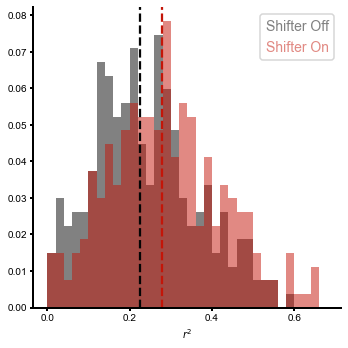

In [10]:
fig, axs4 = plt.subplots(figsize=(5,5))
hbins = .02
sta_titles = ['Shifter Off','Shifter On']
NoShift_clrs = ["#050505", "#C41508"]
move_clrs = ['blue','orange','green','red']
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
for n in range(r2_all.shape[0]):
    ax = axs4
    count,edges = np.histogram(r2_all[n],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=NoShift_clrs[n],width=hbins, alpha=.5,label=sta_titles[n])
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel(xlab,fontsize=fontsize)
    ax.axvline(x=np.nanmean(r2_all[n]), c=NoShift_clrs[n], ls='--')
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0, fancybox=True)
plt.tight_layout()


# Figure 3

### Full Figure

In [11]:
params['do_shuffle']=True
params['nt_glm_lag']=5
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
Shuff_List = []
for date_ani in dates_all:
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    Shuff_List.append(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))

    # mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best.h5'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    # Shuff_List.append(list((params['save_dir'].parent.parent.parent / date_ani).rglob(mod_name)))
Shuff_List = np.stack(Shuff_List)
Shuff_List

array([[PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel0/version_0/GLM_Pytorch_Mot_dt050_T05_MovModel0_NB10000_Kfold00_shuffled_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_shuffled_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel2/version_0/GLM_Pytorch_Add_dt050_T05_MovModel2_NB10000_Kfold00_shuffled_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/CropInputs/MovModel3/version_0/GLM_Pytorch_Mul_dt050_T05_MovModel3_NB10000_Kfold00_shuffled_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/hf1_wn/CropInputs/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_shuffled_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMoto

In [36]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
Shuff_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    # Shuff_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    # Shuff_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    # Shuff_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(sorted(Shuff_List[da])):
        GLM_Data = ioh5.load(fmod)
        Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        Shuff_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        Shuff_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = GLM_Data['cc_test'].copy()
        Shuff_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        Shuff_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            Shuff_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            cc_FMHF_RF = np.zeros(Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_all'].shape[0])
            for celln in np.arange(Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_all'].shape[0]):
                cc_FMHF_RF[celln] = np.corrcoef(Shuff_data[date_ani][mod_titles[1]+'_rf_all'][celln,0].flatten(),Shuff_data[date_ani][mod_titles[-1]+'_rf_all'][celln,0].flatten())[0,1]
            Shuff_data[date_ani][mod_titles[ModelRun]+'_FMHF_cc'] = cc_FMHF_RF


da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [37]:
shuff_FMHF = np.hstack([Shuff_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
FM_RF_shuff = np.concatenate([Shuff_data[date_ani2[da]]['vis_rf_all'][:,0]  for da in range(len(dates_all))],axis=0)
HF_RF_shuff = np.concatenate([Shuff_data[date_ani2[da]]['HF_rf_all'][:,0]  for da in range(len(dates_all))],axis=0)
FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)

In [38]:
shuff_r2 = []
for celln in np.arange(FM_RF_shuff.shape[0]):
    for celln2 in np.arange(HF_RF_shuff.shape[0]):
        shuff_r2.append(np.corrcoef(FM_RF_shuff[celln].flatten(),HF_RF_shuff[celln2].flatten())[0,1])
shuff_r2 = np.array(shuff_r2)


In [39]:
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
shuff_nstd = 2*np.nanstd(shuff_r2)
shuff_nstd, np.nanmean(shuff_r2),np.nanmean(vals_FMHF)

(0.185660410083533, -0.0005985395567979699, 0.11935145140943795)

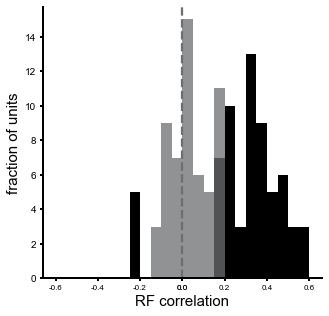

In [40]:
snr_thresh=4
noise_thresh=10 #6
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
vals_HF = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
FM_RF_all_snr=FM_RF_all.copy()
HF_RF_all_snr=HF_RF_all.copy()
# FM_RF_all_snr[(np.abs(FM_RF_all_snr)<1e-6)] = np.nan
# HF_RF_all_snr[(np.abs(HF_RF_all_snr)<1e-6)] = np.nan
snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])[((snr_FM>snr_thresh) & (snr_HF>snr_thresh) & (mean_HF_fr>1) & (vals_Vis>.01)&(vals_HF>.01))]
cc_nsig = vals_FMHF[((np.abs(vals_FMHF)<shuff_nstd))]
cc_sig = vals_FMHF[((np.abs(vals_FMHF)>shuff_nstd))]


hbins=.05
lim0 = -.6
lim1 = .65
dlim = .2
ylim = .25
dylim = .1
xticks = np.hstack((np.arange(lim0,0,dlim),0,np.arange(0,lim1,dlim)))
count,edges = np.histogram(cc_sig,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])

fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.bar(edges_mid, count,color='k',width=hbins, alpha=1) #/(len(cc_sig)+len(cc_nsig))
count,edges = np.histogram(cc_nsig,bins=np.arange(lim0,lim1,hbins))
ax.bar(edges_mid, count,color='#6D6E71',width=hbins, alpha=.75) #/(len(cc_sig)+len(cc_nsig))

ax.set_xlabel('RF correlation',fontsize=fontsize+5)
ax.set_ylabel('fraction of units',fontsize=fontsize+5)
# ax.set_yticks(np.arange(0,ylim,dylim))
# ax.set_yticklabels(np.round(np.arange(0,ylim,dylim),decimals=3),fontsize=fontsize-2)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks,decimals=1), fontsize=fontsize-2)
ax.axvline(x=0,c='#6D6E71',ls='--')

# FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
# HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
# FM_RF_all_snr=FM_RF_all.copy()
# HF_RF_all_snr=HF_RF_all.copy()
# FM_RF_all_snr[(np.abs(FM_RF_all_snr)<1e-6)] = np.nan
# HF_RF_all_snr[(np.abs(HF_RF_all_snr)<1e-6)] = np.nan
# snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
# snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))
# mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
# vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])[((snr_FM>snr_thresh) & (snr_HF>snr_thresh) & (mean_HF_fr>1) & (FM_noise<noise_thresh)&(HF_noise<noise_thresh))]
# cc_nsig = vals_FMHF[((np.abs(vals_FMHF)<shuff_nstd))]
# cc_sig = vals_FMHF[((np.abs(vals_FMHF)>shuff_nstd))]

# xticks = np.hstack((np.arange(lim0,0,dlim),0,np.arange(0,lim1,dlim)))
# count,edges = np.histogram(cc_sig,bins=np.arange(lim0,lim1,hbins))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])

# ax.bar(edges_mid, count,color='r',width=hbins, alpha=.5) #/(len(cc_sig)+len(cc_nsig))
# count,edges = np.histogram(cc_nsig,bins=np.arange(lim0,lim1,hbins))
# ax.bar(edges_mid, count,color='#6D6E71',width=hbins, alpha=1) #/(len(cc_sig)+len(cc_nsig))


In [41]:
print('%>2std={:.2f}, Nunits={}, (%>2std & cc>0)={:.2f}'.format(len(cc_sig)/(len(cc_sig)+len(cc_nsig)),(len(cc_sig)+len(cc_nsig)), len(cc_sig[cc_sig>0])/(len(cc_sig)+len(cc_nsig))))

%>2std=0.54, Nunits=123, (%>2std & cc>0)=0.50


### Full Figure V2

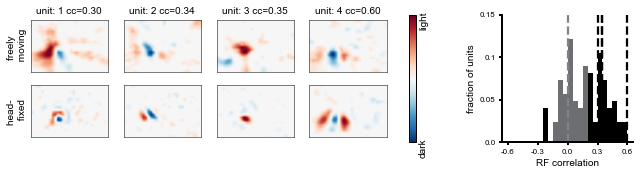

In [42]:
fontsize=10
da=0
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
sorted_r2 = np.argsort(vals_FMHF)[::-1] ##### Sorted indecies for R2
hf_inds = np.arange(mean_HF_fr.shape[0])[mean_HF_fr<1]
sorted_r2 = np.delete(sorted_r2,[np.argwhere(sorted_r2 == hf_inds[n])[0,0] for n in range(len(hf_inds))])
RF_all = np.stack((np.vstack([All_data[date_ani2[da]]['vis_rf_up'] for da in range(len(dates_all))]),np.vstack([All_data[date_ani2[da]]['HF_rf_up'] for da in range(len(dates_all))])))
fig1 = plt.figure(constrained_layout=False, figsize=(10.8,2.3432))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.2,hspace=.3)
lag_ls = [-50,0,50]

########## Fig 3A ########## 
cells = [58,61,64,101] #[61,34, 64, 58]#[62,61,101]# 
num_cells = len(cells)

gs00 = gridspec.GridSpecFromSubplotSpec(2, num_cells, subplot_spec=gs0[:,:3],wspace=.2,hspace=.05)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
xcut1=0
xcut2=-0
ycut1=0
ycut2=-0
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(RF_all[0,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im2 = axs1[0,n].imshow(RF_all[0,cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    crange1 = np.max(np.abs(RF_all[1,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im1 = axs1[1,n].imshow(RF_all[1,cell, 2], 'RdBu_r', vmin=-crange1, vmax=crange1) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    axs1[0,n].set_title('unit: {} cc={:.02f}'.format(n+1,vals_FMHF[cell]), fontsize=fontsize)

axs1[1,0].set_ylabel('head- \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1)
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   

########## Fig 3B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:,3:],wspace=.05,hspace=.1)
axs2 = fig1.add_subplot(gs01[0,0])

snr_thresh=4
noise_thresh=10#6
FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
FM_RF_all_snr=FM_RF_all.copy()
HF_RF_all_snr=HF_RF_all.copy()
# FM_RF_all_snr[(np.abs(FM_RF_all_snr)<1e-6)] = np.nan
# HF_RF_all_snr[(np.abs(HF_RF_all_snr)<1e-6)] = np.nan
snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])[((snr_FM>snr_thresh) & (snr_HF>snr_thresh) & (mean_HF_fr>1) & (vals_Vis>.01)&(vals_HF>.01))]
cc_nsig = vals_FMHF[((np.abs(vals_FMHF)<shuff_nstd))]
cc_sig = vals_FMHF[((np.abs(vals_FMHF)>shuff_nstd))]

# vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
# vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
# vals_FMHF_th = (vals_Vis>.05) & (vals_HF>.05)
ax = axs2
hbins=.05
lim0 = -.6
lim1 = .65
dlim = .2
ylim = .2
dylim = .05
xticks = [-.6,-.3,0,.3,.6] #np.hstack((np.arange(lim0,0,dlim),0,np.arange(0,lim1,dlim)))
count,edges = np.histogram(cc_sig,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/(len(cc_sig)+len(cc_nsig)),color='k',width=hbins, alpha=1,zorder=1) 
count,edges = np.histogram(cc_nsig,bins=np.arange(lim0,lim1,hbins))
ax.bar(edges_mid, count/(len(cc_sig)+len(cc_nsig)),color='#6D6E71',width=hbins, alpha=1) 

ax.set_xlabel('RF correlation',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks(np.arange(0,ylim,dylim))
ax.set_yticklabels(np.round(np.arange(0,ylim,dylim),decimals=3),fontsize=fontsize-2)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks,decimals=1), fontsize=fontsize-2)
ax.axvline(x=0,c='#828387',ls='--')
# axs2.set_xlim(0,.8)
# axs2.set_ylim(0,.25)
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
for cell in cells:
    ax.axvline(x=vals_FMHF[cell],ls='--',c='k')
# ax.annotate("", xy=(.75, 0.25), xytext=(.2, .2), arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
# plt.show()
# fig1.savefig(paper_fig_dir/'Figure3_draft2.pdf', facecolor='white', transparent=True, bbox_inches='tight')


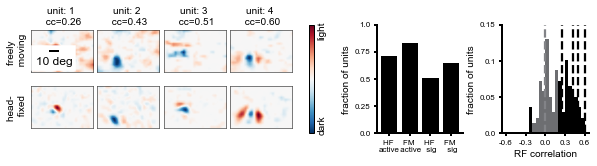

In [164]:
fontsize=10
da=0
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
sorted_r2 = np.argsort(vals_FMHF)[::-1] ##### Sorted indecies for R2
hf_inds = np.arange(mean_HF_fr.shape[0])[mean_HF_fr<1]
sorted_r2 = np.delete(sorted_r2,[np.argwhere(sorted_r2 == hf_inds[n])[0,0] for n in range(len(hf_inds))])
RF_all = np.stack((np.vstack([All_data[date_ani2[da]]['vis_rf_up'] for da in range(len(dates_all))]),np.vstack([All_data[date_ani2[da]]['HF_rf_up'] for da in range(len(dates_all))])))
fig1 = plt.figure(constrained_layout=False, figsize=(10.,2.))
gs0 = gridspec.GridSpec(nrows=2, ncols=5, figure=fig1,wspace=.2,hspace=.3)
lag_ls = [-50,0,50]

########## Fig 3A ########## 
cells = [3,167,62,101] #[58,61,34, 64, 58]#[62,61,101]# 
num_cells = len(cells)

gs00 = gridspec.GridSpecFromSubplotSpec(2, num_cells, subplot_spec=gs0[:,:3],wspace=.07,hspace=.05)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
xcut1=0
xcut2=-0
ycut1=0
ycut2=-0
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(RF_all[0,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im2 = axs1[0,n].imshow(RF_all[0,cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    crange1 = np.max(np.abs(RF_all[1,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im1 = axs1[1,n].imshow(RF_all[1,cell, 2], 'RdBu_r', vmin=-crange1, vmax=crange1) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    axs1[0,n].set_title('unit: {} \n cc={:.02f}'.format(n+1,vals_FMHF[cell]), fontsize=fontsize).set_multialignment('center')

scale1 = ScaleBar(dx=.5, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} deg')
axs1[0,0].add_artist(scale1)
axs1[1,0].set_ylabel('head- \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1)
cbar2.set_ticks([-crange2+.002, crange2])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   

########## Fig 3B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[:,3:],wspace=.45,hspace=.1)


### Shuffle bar
shuff_Mot = np.hstack([Shuff_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
shuff_Vis = np.hstack([Shuff_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
shuff_Add = np.hstack([Shuff_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
shuff_Mul = np.hstack([Shuff_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
shuff_HF = np.hstack([Shuff_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
vals_HF = np.hstack([All_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])
HF_meanfr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
FM_meanfr = np.hstack([All_data[date_ani2[da]]['actual_meanfr'] for da in range(len(dates_all))])
tot_Ncells = 128+67+56+71
# % active HF,FM
Nactive_HF = np.sum(HF_meanfr>1)/tot_Ncells
Nactive_FM = np.sum(FM_meanfr>1)/tot_Ncells

# % significant based on max of shuffle
Nsig_HF = np.sum(vals_HF>np.nanmax(shuff_HF))/vals_Vis.shape[0]
Nsig_FM = np.sum(vals_Vis>np.nanmax(shuff_Vis))/vals_Vis.shape[0]

# gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:,4],wspace=.05,hspace=.1)
axs3 = fig1.add_subplot(gs01[0,0])
ax = axs3
ylim =1.25
dylim = .25
ax.bar([0,1,2,3],[Nactive_HF,Nactive_FM,Nsig_HF,Nsig_FM],color='k')
ax.set_yticks(np.arange(0,ylim,dylim))
ax.set_yticklabels(np.round(np.arange(0,ylim,dylim),decimals=3),fontsize=fontsize-2)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['HF \nactive','FM \n active','HF \n sig','FM \n sig'],fontsize=fontsize-2)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_ylim([0,1])




axs2 = fig1.add_subplot(gs01[0,1])

snr_thresh=4
noise_thresh=10#6
FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
FM_RF_all_snr=FM_RF_all.copy()
HF_RF_all_snr=HF_RF_all.copy()
# FM_RF_all_snr[(np.abs(FM_RF_all_snr)<1e-6)] = np.nan
# HF_RF_all_snr[(np.abs(HF_RF_all_snr)<1e-6)] = np.nan
snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])[((snr_FM>snr_thresh) & (snr_HF>snr_thresh) & (mean_HF_fr>1) & (vals_Vis>.01)&(vals_HF>.01))]
cc_nsig = vals_FMHF[((np.abs(vals_FMHF)<shuff_nstd))]
cc_sig = vals_FMHF[((np.abs(vals_FMHF)>shuff_nstd))]

# vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
# vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
# vals_FMHF_th = (vals_Vis>.05) & (vals_HF>.05)
ax = axs2
hbins=.05
lim0 = -.6
lim1 = .65
dlim = .2
ylim = .2
dylim = .05
xticks = [-.6,-.3,0,.3,.6] #np.hstack((np.arange(lim0,0,dlim),0,np.arange(0,lim1,dlim)))
count,edges = np.histogram(cc_sig,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/(len(cc_sig)+len(cc_nsig)),color='k',width=hbins, alpha=1,zorder=1) 
count,edges = np.histogram(cc_nsig,bins=np.arange(lim0,lim1,hbins))
ax.bar(edges_mid, count/(len(cc_sig)+len(cc_nsig)),color='#6D6E71',width=hbins, alpha=1) 

ax.set_xlabel('RF correlation',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks(np.arange(0,ylim,dylim))
ax.set_yticklabels(np.round(np.arange(0,ylim,dylim),decimals=3),fontsize=fontsize-2)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks,decimals=1), fontsize=fontsize-2)
ax.axvline(x=0,c='#828387',ls='--')
# axs2.set_xlim(0,.8)
# axs2.set_ylim(0,.25)
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
for cell in cells:
    ax.axvline(x=vals_FMHF[cell],ls='--',c='k')
# ax.annotate("", xy=(.75, 0.25), xytext=(.2, .2), arrowprops=dict(arrowstyle="->"))



plt.tight_layout()
# plt.show()
fig1.savefig(paper_fig_dir/'Figure3_draft3.pdf', transparent=True, bbox_inches='tight')


## Vis fit comparision with shuffle

In [20]:
shuff_Mot = np.hstack([Shuff_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
shuff_Vis = np.hstack([Shuff_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
shuff_Add = np.hstack([Shuff_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
shuff_Mul = np.hstack([Shuff_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
shuff_HF = np.hstack([Shuff_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
vals_HF = np.hstack([All_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])
HF_meanfr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
FM_meanfr = np.hstack([All_data[date_ani2[da]]['actual_meanfr'] for da in range(len(dates_all))])
tot_Ncells = 128+67+56+71

(0.0, 1.0)

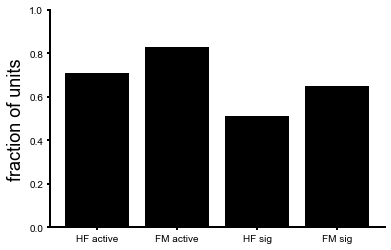

In [21]:
# % active HF,FM
Nactive_HF = np.sum(HF_meanfr>1)/tot_Ncells
Nactive_FM = np.sum(FM_meanfr>1)/tot_Ncells

# % significant based on max of shuffle
Nsig_HF = np.sum(vals_HF>np.nanmax(shuff_HF))/vals_Vis.shape[0]
Nsig_FM = np.sum(vals_Vis>np.nanmax(shuff_Vis))/vals_Vis.shape[0]

fig,axs = plt.subplots()
ax = axs
ax.bar([0,1,2,3],[Nactive_HF,Nactive_FM,Nsig_HF,Nsig_FM],color='k')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['HF active','FM active','HF sig','FM sig'])
ax.set_ylabel('fraction of units')
ax.set_ylim([0,1])



In [42]:
cell = 22
np.corrcoef(RF_all[0,cell, 2].flatten(),RF_all[1,cell, 2].flatten())

array([[1.        , 0.05095867],
       [0.05095867, 1.        ]])

In [61]:
arr1inds = np.where(vals_FMHF>.2)[0].argsort()
sorted_arr1 = np.where(vals_FMHF>.2)[0][arr1inds[::-1]]
sorted_arr1,np.where(vals_FMHF>.2)[0]

(array([265, 264, 256, 254, 251, 250, 249, 247, 246, 245, 244, 242, 237,
        235, 233, 232, 230, 228, 225, 224, 221, 212, 195, 191, 180, 168,
        167, 165, 159, 155, 154, 152, 148, 143, 142, 141, 139, 138, 137,
        135, 134, 133, 132, 130, 120, 119, 118, 117, 112, 105, 101,  99,
         97,  95,  93,  90,  89,  87,  80,  77,  76,  72,  70,  65,  64,
         62,  61,  60,  58,  57,  56,  55,  53,  52,  50,  49,  44,  42,
         41,  37,  36,  34,  19,  18,  11,  10,   7,   3]),
 array([  3,   7,  10,  11,  18,  19,  34,  36,  37,  41,  42,  44,  49,
         50,  52,  53,  55,  56,  57,  58,  60,  61,  62,  64,  65,  70,
         72,  76,  77,  80,  87,  89,  90,  93,  95,  97,  99, 101, 105,
        112, 117, 118, 119, 120, 130, 132, 133, 134, 135, 137, 138, 139,
        141, 142, 143, 148, 152, 154, 155, 159, 165, 167, 168, 180, 191,
        195, 212, 221, 224, 225, 228, 230, 232, 233, 235, 237, 242, 244,
        245, 246, 247, 249, 250, 251, 254, 256, 264, 265]))

In [ ]:
fontsize=10
da=0
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
sorted_r2 = np.argsort(vals_FMHF)[::-1] ##### Sorted indecies for R2
hf_inds = np.arange(mean_HF_fr.shape[0])[mean_HF_fr<1]
sorted_r2 = np.delete(sorted_r2,[np.argwhere(sorted_r2 == hf_inds[n])[0,0] for n in range(len(hf_inds))])
RF_all = np.stack((np.vstack([All_data[date_ani2[da]]['vis_rf_up'] for da in range(len(dates_all))]),np.vstack([All_data[date_ani2[da]]['HF_rf_up'] for da in range(len(dates_all))])))
fig1 = plt.figure(constrained_layout=False, figsize=(5*len(sorted_arr1),5))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.2,hspace=.3)
lag_ls = [-50,0,50]

########## Fig 3A ########## 
cells = np.where(vals_FMHF>.2)[0]# [22,101,61,64,62]#[101,64,61,62] # 
num_cells = len(cells)

gs00 = gridspec.GridSpecFromSubplotSpec(2, num_cells, subplot_spec=gs0[:,:3],wspace=.2,hspace=.05)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
xcut1=0
xcut2=-0
ycut1=0
ycut2=-0
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(RF_all[0,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im2 = axs1[0,n].imshow(RF_all[0,cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    crange1 = np.max(np.abs(RF_all[1,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im1 = axs1[1,n].imshow(RF_all[1,cell, 2], 'RdBu_r', vmin=-crange1, vmax=crange1) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    axs1[0,n].set_title('unit: {} \n cc={:.02f}'.format(cell,vals_FMHF[cell]), fontsize=fontsize)

axs1[1,0].set_ylabel('head- \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1)
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   

fig1.savefig(paper_fig_dir/'RF_explore.pdf', facecolor='white', transparent=True, bbox_inches='tight')

# Figure 4

## Full Figure CC Version

In [349]:
da = 3
args['free_move']=True
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (71,)


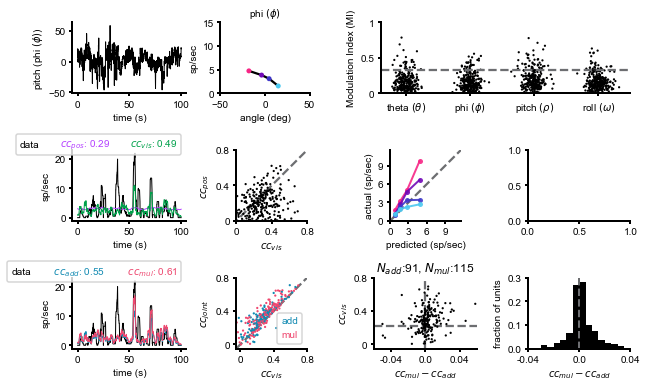

In [359]:
###### Fig 4 with CC

titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#B541FF","#00A14B","#118ab2","#ef476f","#073b4c"]
celln = 49#52#106
modN = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]]['vis_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,1:],wspace=.8,hspace=.7)
gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[0,1:])])
axs0aa = np.array([fig.add_subplot(gs01[0,:1])])#,fig.add_subplot(gs00[0,1]),fig.add_subplot(gs00[0,2])])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 1
ax = axs0aa[0]
ax.plot(pred_time,move_test[t:t+dt,modeln],'k',lw=1)
ax.set_ylabel('pitch ({})'.format(titles[modeln]),fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
# metric = move_data[params['bin_length']:-params['bin_length'],modeln]
# nranges = np.quantile(metric,quartiles)
# stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
# stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
# stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

# edge_mids = np.quantile(metric,spk_percentile2)#
# # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
# ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
# ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
# ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
# xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
# ax.set_xlim(-xlim_range,xlim_range)
# ax.set_ylim(0,15)
# ax.set_xlabel('angle (deg)',fontsize=fontsize)
# ax.set_ylabel('sp/sec',fontsize=fontsize)
# ax.set_title(titles[modeln],fontsize=fontsize)

ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

########## Fig 4B ########## 
##### Modulation Index Histograms #####
x_sc = np.stack((np.random.normal(0, 0.1, tuning_sig_all.shape[0]), np.random.normal(1, 0.1, tuning_sig_all.shape[0]),np.random.normal(2, 0.1, tuning_sig_all.shape[0]),np.random.normal(3, 0.1, tuning_sig_all.shape[0])))
ax = axs0a[1]
for modeln in np.arange(0,len(titles)):
    ax.scatter(x_sc[modeln],tuning_sig_all[:,modeln,0],s=5,c='k',edgecolors='none')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles,fontsize=fontsize)
ax.set_ylim([0,1])
ax.set_yticks([0,.5,1])
ax.set_yticklabels([0,.5,1],fontsize=fontsize)
ax.set_ylabel('Modulation Index (MI)',fontsize=fontsize)
ax.axhline(y=.33,ls='--',color='#6D6E71')


# dwidth = .1
# for modeln in np.arange(0,len(titles)):
#     ax = axs0a[modeln+1]
#     count,edges = np.histogram(tuning_sig_all[:,modeln], bins=np.arange(0,1.1,dwidth))
#     edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
#     ax.bar(edges_mid, count/len(tuning_sig_all[:,modeln]),color='k',width=dwidth,alpha=1)
#     ax.axvline(x=.33,ls='--',color='#6D6E71')
#     ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
#     ax.set_xlabel('MI', fontsize=fontsize)
#     # ax.set_ylabel('fraction of units', fontsize=fontsize)
#     ax.set_xlim(0,1)
#     ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
#     ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
#     ax.set_ylim(0,.4)
# axs0a[1].set_ylabel('fraction of units', fontsize=fontsize)

########## Fig 4C/G ########## 
axs1a = np.array([fig.add_subplot(gs01[1,0])])
axs2a = np.array([fig.add_subplot(gs01[2,0])])

cmap = mpl.colors.ListedColormap(q_clrs)

celln = 49#52#106
da = 3
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-100)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs1a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles[:-1]))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(0,2):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)


##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln] for modN in range(len(mod_titles[:-1]))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(2,len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r' $cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)



gs02 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[1:,1:],wspace=.5,hspace=.8)
axs3a = np.array([fig.add_subplot(gs02[n,m]) for n in range(2) for m in range(3)]).reshape(2,3)

########## Fig 4D ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])


tuning_idx = np.where(tuning_sig_all2)[0]
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=5,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(0,.8)
ax.set_xlim(0,.8)

########## Fig 4E ########## 

ax = axs3a[0,1]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts 
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
    ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
    ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (-.05, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
# ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
ax.set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_xticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.set_yticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.axis('square')
ax.set(xlim=lims, ylim=lims)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)


########## Fig 4H ########## 

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
AvM_thresh = (~np.isnan(vals_Vis)) & (~np.isnan(vals_AM))
ax = axs3a[1,0]
scatter=ax.scatter(vals_Vis[AvM_thresh],vals_AM[AvM_thresh],s=5,c=AvM[AvM_thresh],cmap=cmap_mod,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{joint}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(-.05, .8)
ax.set_xlim(-.05, .8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]


##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,1]
im = ax.scatter(diff[th],increase[th],s=5,c='k',edgecolors='none')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_title(r'$N_{{add}}$:{}, $N_{{mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize+2)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.06,.06)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)


##### Hist of Add-Mul #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,2]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_xlim([-.04, .04])
ax.set_yticks([0,.1,.2,.3])

plt.show()
gs0.tight_layout(fig)

# fig.savefig(paper_fig_dir/'Fig4_draft_V4_Cell52_101521_cc_new_tuning.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [331]:
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
np.argsort(vals_Mul-vals_Add)[::-1]
# np.argsort(vals_Mul-vals_Add)[::-1]

array([ 27, 228, 265, 137, 138, 229, 221,  80, 160, 224,  94, 124,  39,
       155, 153, 103, 192,  84,  85, 232, 147,  31, 157, 139,   6,   5,
       143, 112,  18, 105, 129,  49,  72,  99, 246,  90, 154, 108,  62,
        82,  93, 181, 116, 209, 107,  83, 172,  74,  54,  26,  37, 218,
       237, 223, 234,  59, 257, 177, 188, 206, 203, 156, 117,  21, 174,
        75,  88,  45, 205, 130, 140,  30, 145, 202, 171, 213,  65,  87,
        41, 212,  86, 166,  43,  76, 179, 100,  63, 123, 110, 149, 127,
       106, 161, 239, 191,  13, 200, 128,  12,  28, 152, 226, 241,  40,
       189, 251,  71, 193, 245,   7, 183,  38, 158, 214, 150, 151,  50,
        29, 216,   8,  33, 261, 250, 163, 201,  23,  10,  64,  14, 165,
       196, 180,  95, 109, 238, 256, 167,  53, 259,  66, 254, 248, 114,
       169, 244, 164,  96,  92, 266,  15,  11, 118, 162, 208, 264, 168,
        78, 122, 136, 263, 186, 220, 253,  48, 233, 204, 219, 262,  32,
       102, 115, 231, 175, 255,  47,  91,   3,  44, 236, 217, 23

In [52]:
high_mod = np.sum(np.any(tuning_sig_all.squeeze()>.33,axis=1))/tuning_sig_all.shape[0]
print('above .33: {:.03f}'.format(high_mod))

above .33: 0.272


IndexError: index 265 is out of bounds for axis 1 with size 108

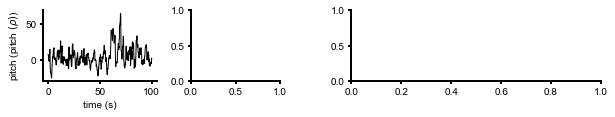

In [296]:
###### Fig 4 with CC

titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#B541FF","#00A14B","#118ab2","#ef476f","#073b4c"]
celln = 265#52#106
modN = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=pred_all.shape[1] # All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = pred_all[:,celln,1] # All_data[date_ani2[da]]['vis_pred_smooth'][:,celln]#/params['model_dt']
nspcell = act_all[:,celln] # All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,1:],wspace=.8,hspace=.7)
gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[0,1:])])
axs0aa = np.array([fig.add_subplot(gs01[0,:1])])#,fig.add_subplot(gs00[0,1]),fig.add_subplot(gs00[0,2])])

top_yaxs = np.max(ax_lims_all[celln])+2*np.max(test_std[celln])#tuning_stds
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 0
ax = axs0aa[0]
ax.plot(pred_time,move_test[t:t+dt,2],'k',lw=1)
ax.set_ylabel('pitch ({})'.format(titles[2]),fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)

modeln = 2
ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

########## Fig 4B ########## 
##### Modulation Index Histograms #####
x_sc = np.stack((np.random.normal(0, 0.1, tuning_sig_all.shape[0]), np.random.normal(1, 0.1, tuning_sig_all.shape[0]),np.random.normal(2, 0.1, tuning_sig_all.shape[0]),np.random.normal(3, 0.1, tuning_sig_all.shape[0])))
ax = axs0a[1]
for modeln in np.arange(0,len(titles)):
    ax.scatter(x_sc[modeln],tuning_sig_all[:,modeln,0],s=5,c='k',edgecolors='none')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles,fontsize=fontsize)
ax.set_ylim([0,1])
ax.set_yticks([0,.5,1])
ax.set_yticklabels([0,.5,1],fontsize=fontsize)
ax.set_ylabel('Modulation Index (MI)',fontsize=fontsize)
ax.axhline(y=.33,ls='--',color='#6D6E71')

########## Fig 4C/G ########## 
axs1a = np.array([fig.add_subplot(gs01[1,0])])
axs2a = np.array([fig.add_subplot(gs01[2,0])])

cmap = mpl.colors.ListedColormap(q_clrs)

celln = 27#52#106
da = 0
t = np.argmin(np.abs((np.arange(act_all.shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(act_all.shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs1a[0]
zorder = np.argsort([vals_all[celln,modN] for modN in range(len(mod_titles[:-1]))])+1
ax.plot(pred_time,act_all[t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(0,2):
    ax.plot(pred_time,pred_all[t:t+dt,celln,modN],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],vals_all[celln,modN]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)


##### Plotting Firing Rate #####
# pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2a[0]
ax.plot(pred_time,act_all[t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(2,4):
    ax.plot(pred_time,pred_all[t:t+dt,celln,modN],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],vals_all[celln,modN]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)



gs02 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[1:,1:],wspace=.5,hspace=.8)
axs3a = np.array([fig.add_subplot(gs02[n,m]) for n in range(2) for m in range(3)]).reshape(2,3)

########## Fig 4D ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])


tuning_idx = np.where(tuning_sig_all2)[0]
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=5,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(0,.8)
ax.set_xlim(0,.8)

########## Fig 4E ########## 

ax = axs3a[0,1]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts 
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
    ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
    ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (-.05, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
# ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
ax.set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_xticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.set_yticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.axis('square')
ax.set(xlim=lims, ylim=lims)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)


########## Fig 4H ########## 

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
AvM_thresh = (~np.isnan(vals_Vis)) & (~np.isnan(vals_AM))
ax = axs3a[1,0]
scatter=ax.scatter(vals_Vis[AvM_thresh],vals_AM[AvM_thresh],s=5,c=AvM[AvM_thresh],cmap=cmap_mod,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{joint}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(-.05, .8)
ax.set_xlim(-.05, .8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]


##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,1]
im = ax.scatter(diff[th],increase[th],s=5,c='k',edgecolors='none')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_title(r'$N_{{add}}$:{}, $N_{{mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize+2)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.06,.06)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)


##### Hist of Add-Mul #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,2]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_xlim([-.04, .04])
ax.set_yticks([0,.1,.2,.3])

plt.show()
gs0.tight_layout(fig)

# fig.savefig(paper_fig_dir/'Fig4_draft_V4_Cell52_101521_cc_new_tuning.pdf', facecolor='white', transparent=True, bbox_inches='tight')


Text(0, 0.5, 'fraction of units')

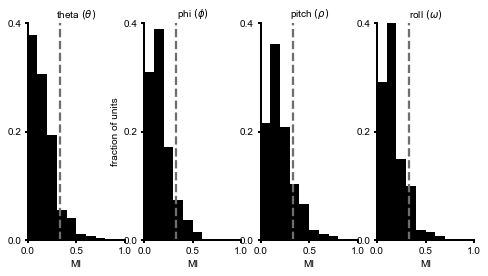

In [109]:
fig, axs = plt.subplots(1,4,figsize=(8,4))

########## Fig 4B ########## 
##### Modulation Index Histograms #####
dwidth = .1
for modeln in np.arange(0,len(titles)):
    ax = axs[modeln]
    count,edges = np.histogram(tuning_sig_all[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(tuning_sig_all[:,modeln]),color='k',width=dwidth,alpha=1)
    ax.axvline(x=.33,ls='--',color='#6D6E71')
    ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
    ax.set_xlabel('MI', fontsize=fontsize)
    # ax.set_ylabel('fraction of units', fontsize=fontsize)
    ax.set_xlim(0,1)
    ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_ylim(0,.4)
axs[1].set_ylabel('fraction of units', fontsize=fontsize)


Text(0, 0.5, 'Modulation Index (MI)')

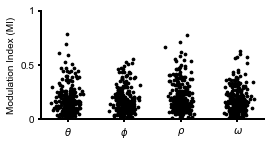

In [48]:
x_sc = np.stack((np.random.normal(0, 0.1, tuning_sig_all.shape[0]), np.random.normal(1, 0.1, tuning_sig_all.shape[0]),np.random.normal(2, 0.1, tuning_sig_all.shape[0]),np.random.normal(3, 0.1, tuning_sig_all.shape[0])))
fig, axs = plt.subplots(figsize=(4,2))
ax = axs
for modeln in np.arange(0,len(titles)):
    ax.scatter(x_sc[modeln],tuning_sig_all[:,modeln,0],s=5,c='k')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles,fontsize=fontsize)
ax.set_ylim([0,1])
ax.set_yticks([0,.5,1])
ax.set_yticklabels([0,.5,1],fontsize=fontsize)
ax.set_ylabel('Modulation Index (MI)',fontsize=fontsize)

[Text(0, 0, 'theta $(\\theta)$'),
 Text(1, 0, 'phi $(\\phi)$'),
 Text(2, 0, 'pitch $(\\rho)$'),
 Text(3, 0, 'roll $(\\omega)$')]

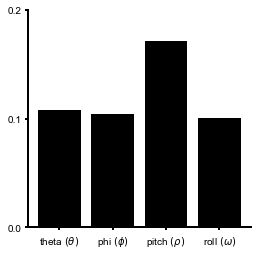

In [27]:
fig, ax = plt.subplots(figsize=(4,4))
active_perc = (np.sum(tuning_sig_all>.33,axis=0)/tuning_sig_all.shape[0]).squeeze()
ax.bar(np.arange(tuning_sig_all.shape[1]),active_perc, color='k')
ax.set_ylim([0,.2])
ax.set_yticks([0,.1,.2])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(titles,fontsize=fontsize)

In [354]:
# (128 + 67 + 56 )-265 #+ 56)-71,228
(108 + 63 + 45) - 265

-49

In [353]:
[All_data[date_ani2[da]]['mul_cc_test'].shape[0] for da in range(len(dates_all))]

[108, 63, 45, 52]

In [209]:
Ncells = vals_Mot.shape[0]

In [321]:
act_all=[]
pos_all=[]
vis_all=[]
add_all=[]
mul_all=[]
move_all=[]
for n in range(len(dates_all)):
    act_part = np.nan*np.ones((np.max([All_data[date_ani2[da]]['actual_smooth'].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1]))
    pos_part = np.nan*np.ones((np.max([All_data[date_ani2[da]]['actual_smooth'].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1]))
    vis_part = np.nan*np.ones((np.max([All_data[date_ani2[da]]['actual_smooth'].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1]))
    add_part = np.nan*np.ones((np.max([All_data[date_ani2[da]]['actual_smooth'].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1]))
    mul_part = np.nan*np.ones((np.max([All_data[date_ani2[da]]['actual_smooth'].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1]))
    move_part = np.nan*np.ones((np.max([model_move_FM[da].shape[0] for da in range(len(dates_all))]),All_data[date_ani2[n]]['actual_smooth'].shape[1],model_move_FM[n].shape[1]))
    act_part[:All_data[date_ani2[n]]['actual_smooth'].shape[0],:] = All_data[date_ani2[n]]['actual_smooth']
    pos_part[:All_data[date_ani2[n]]['pos_pred_smooth'].shape[0],:] = All_data[date_ani2[n]]['pos_pred_smooth']
    vis_part[:All_data[date_ani2[n]]['vis_pred_smooth'].shape[0],:] = All_data[date_ani2[n]]['vis_pred_smooth']
    add_part[:All_data[date_ani2[n]]['add_pred_smooth'].shape[0],:] = All_data[date_ani2[n]]['add_pred_smooth']
    mul_part[:All_data[date_ani2[n]]['mul_pred_smooth'].shape[0],:] = All_data[date_ani2[n]]['mul_pred_smooth']
    move_part[:model_move_FM[n].shape[0],:,:] = np.repeat(model_move_FM[n][:,np.newaxis,:],[All_data[date_ani2[n]]['actual_smooth'].shape[1]],axis=1)
    act_all.append(act_part)
    pos_all.append(pos_part)
    vis_all.append(vis_part)
    add_all.append(add_part)
    mul_all.append(mul_part)
    move_all.append(move_part)

act_all = np.hstack(act_all)
pos_all = np.hstack(pos_all)
vis_all = np.hstack(vis_all)
add_all = np.hstack(add_all)
mul_all = np.hstack(mul_all)
pred_all = np.stack([pos_all,vis_all,add_all,mul_all],axis=-1)
move_all = np.concatenate(move_all,axis=1)
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
vals_all = np.stack([vals_Mot,vals_Vis,vals_Add,vals_Mul],axis=-1)


In [329]:
diff = np.argsort(vals_Mul-vals_Add)[::-1]
diff[:10]

array([ 27, 228, 265, 137, 138, 229, 221,  80, 160, 224])

In [197]:
da = 2
args['free_move']=True
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (56,)


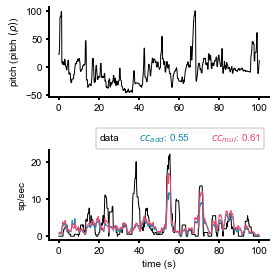

In [278]:
fig, axs = plt.subplots(2,1,figsize=(4,4))

celln = 265#52#106
t = np.argmin(np.abs((np.arange(act_all.shape[0])*params['model_dt'])-100)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #act_all.shape[0] #int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(act_all.shape[0])*params['model_dt'])[0:np.abs(dt)]
zorder = np.argsort([vals_all[celln,modN] for modN in range(len(mod_titles[:-1]))])+1
ax = axs[0]
ax.plot(pred_time,move_all[t:t+dt,celln,2],'k',lw=1)
ax.set_ylabel('pitch ({})'.format(titles[2]),fontsize=fontsize)


ax = axs[1]
ax.plot(pred_time,act_all[t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(2,4):
    ax.plot(pred_time,pred_all[t:t+dt,celln,modN],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],vals_all[celln,modN]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
plt.tight_layout()

### Tuning half/half

In [110]:
nsp_half0 = data['model_nsp'][:data['model_nsp'].shape[0]//2]
nsp_half1 = data['model_nsp'][data['model_nsp'].shape[0]//2:]

In [137]:
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    tuning_thresh = .2
    thresh_fr = 1
    spk_percentile2 = np.arange(.125,1.125,.25)
    quartiles = np.arange(0,1.25,.25)

    nsp_half0 = data['model_nsp'][:data['model_nsp'].shape[0]//2]
    tuning_curves0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],1))
    tuning_curve_edges0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims0 = np.zeros((nsp_half0.shape[-1],model_move.shape[-1]))

    nsp_half1 = data['model_nsp'][data['model_nsp'].shape[0]//2:]
    tuning_curves1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],1))
    tuning_curve_edges1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims1 = np.zeros((nsp_half1.shape[-1],model_move.shape[-1]))
    for i,modeln in enumerate(range(model_move.shape[-1])):
        for celln in np.arange(nsp_half0.shape[1]):
            metric0 = model_move[:data['model_nsp'].shape[0]//2,modeln]
            nranges0 = np.quantile(metric0,quartiles)
            stat_range0, edges0, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='mean',bins=nranges)
            stat_std0, _, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='std',bins=nranges)
            tuning_curves0[celln,modeln] = stat_range0/params['model_dt']
            edge_mids0 = np.quantile(metric0,spk_percentile2)
            tuning_curve_edges0[celln,modeln] = edge_mids0
            tuning_stds0[celln,modeln] = stat_std0.max()

            metric1 = model_move[data['model_nsp'].shape[0]//2:,modeln]
            nranges1 = np.quantile(metric1,quartiles)
            stat_range1, edges1, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='mean',bins=nranges)
            stat_std1, _, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='std',bins=nranges)
            tuning_curves1[celln,modeln] = stat_range1/params['model_dt']
            edge_mids1 = np.quantile(metric1,spk_percentile2)
            tuning_curve_edges1[celln,modeln] = edge_mids1
            tuning_stds1[celln,modeln] = stat_std1.max()
        ax_ylims0[:,modeln] = np.nanmax(tuning_curves0[:,modeln],axis=-1)
        ax_ylims1[:,modeln] = np.nanmax(tuning_curves1[:,modeln],axis=-1)
    tc_mod0 = (np.max(tuning_curves0,axis=-1,keepdims=True)-np.min(tuning_curves0,axis=-1,keepdims=True))/(np.max(tuning_curves0,axis=-1,keepdims=True)+np.min(tuning_curves0,axis=-1,keepdims=True))
    avg_fr0 = np.mean(tuning_curves0,axis=(-1,-2)).squeeze()
    tc_mod1 = (np.max(tuning_curves1,axis=-1,keepdims=True)-np.min(tuning_curves1,axis=-1,keepdims=True))/(np.max(tuning_curves1,axis=-1,keepdims=True)+np.min(tuning_curves1,axis=-1,keepdims=True))
    avg_fr1 = np.mean(tuning_curves1,axis=(-1,-2)).squeeze()

    tuning_sig0 = tc_mod.copy()
    tuning_sig0[avg_fr0<thresh_fr,:,0] = np.nan
    tuning_sig20 = np.any(tuning_sig0>tuning_thresh,axis=1).squeeze()
    tuning_idx0 = np.where(tuning_sig20)[0]
    tuning_sig1 = tc_mod1.copy()
    tuning_sig1[avg_fr1<thresh_fr,:,0] = np.nan
    tuning_sig21 = np.any(tuning_sig1>tuning_thresh,axis=1).squeeze()
    tuning_idx1 = np.where(tuning_sig21)[0]
    tuning_sig = np.concatenate((tuning_sig0,tuning_sig1),axis=2)

    tuning_sig_all.append(tuning_sig)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=0)

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)


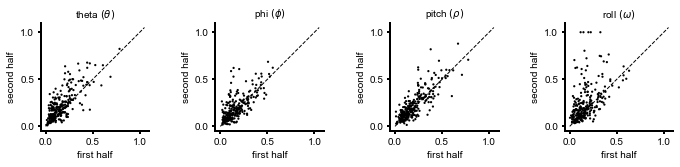

In [163]:
fig, axs = plt.subplots(1,4,figsize=(12,2))
for modeln in range(len(titles)):
    ax = axs[modeln]
    ax.scatter(tuning_sig_all[:,modeln,0],tuning_sig_all[:,modeln,1],s=5,c='k',edgecolors='none')
    ax.plot(np.linspace(0,1.05,100),np.linspace(0,1.05,100),c='k',lw=1,ls='--')
    ax.set_xticks([0,.5,1])
    ax.set_yticks([0,.5,1])
    ax.set_xlabel('first half',fontsize=fontsize)
    ax.set_ylabel('second half',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)
    ax.axis('square')


## Shuffle Data

In [15]:
args['free_move'] = True
args['date_ani'] = date_ani
args['NoL1']=False
args['do_shuffle']=True
args['Nepochs'] = 10000
params,_,_ = load_params(1,Kfold,args,debug=True)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
# ModelList_all.append(ModelList)
ModelList

IndexError: list index out of range

In [25]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_shuff_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['do_shuffle']=True
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    # model_move_FM.append(model_move)
    test_shuff_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    # model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
# test_std=np.hstack(test_std)
# tuning_sig_all2 = np.hstack(tuning_sig_all2)
# tuning_sig_all = np.vstack(tuning_sig_all)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)


Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)


In [26]:
ModelList_all
# mod_name

array([[PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/RevisionSims/MovModel0/version_0/GLM_Pytorch_Mot_dt050_T05_MovModel0_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/RevisionSims/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/RevisionSims/MovModel2/version_0/GLM_Pytorch_Add_dt050_T05_MovModel2_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/fm1/RevisionSims/MovModel3/version_0/GLM_Pytorch_Mul_dt050_T05_MovModel3_NB10000_Kfold00_best.h5'),
        PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/070921/J553RT/hf1_wn/RevisionSims/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5')],
       [PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data4/101521/J559NC/fm1/

In [27]:

sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
Shuff_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    Shuff_data[date_ani]['actual_meanfr'] = np.mean(test_shuff_nsp_all[da],axis=0)/params['model_dt']
    Shuff_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_shuff_nsp_all[da])[params['bin_length']:-params['bin_length']]
    Shuff_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # Shuff_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        Shuff_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        Shuff_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_shuff_nsp_all[da],axis=0)
        if (ModelRun == 0):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            Shuff_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            Shuff_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],Shuff_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(Shuff_data[date_ani]['actual_smooth'].shape[1])])
            Shuff_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],Shuff_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(Shuff_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            Shuff_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],Shuff_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(Shuff_data[date_ani]['actual_HF_smooth'].shape[1])])
            Shuff_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(Shuff_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],Shuff_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(Shuff_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            Shuff_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(Shuff_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(Shuff_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(Shuff_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),Shuff_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            Shuff_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [56]:
All_data[date_ani2[da]]['vis_rf_all'].shape,All_data[date_ani2[da]]['vis_rf_up'][22,2].shape

((108, 5, 30, 40), (120, 160))

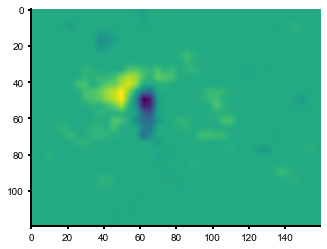

In [46]:
plt.imshow(All_data[date_ani2[da]]['vis_rf_up'][22,2])

In [155]:
All_data[date_ani2[da]].keys()

dict_keys(['actual_meanfr', 'actual_smooth', 'actual_HF_smooth', 'pos_pred_smooth', 'pos_vloss_all', 'pos_vloss_trace', 'pos_moveW', 'pos_cc_test', 'pos_r2_test', 'vis_pred_smooth', 'vis_vloss_all', 'vis_vloss_trace', 'vis_loss_regcv', 'vis_rf_up', 'vis_rf_all', 'vis_cc_test', 'vis_r2_test', 'add_pred_smooth', 'add_vloss_all', 'add_vloss_trace', 'add_moveW', 'add_cc_test', 'add_r2_test', 'mul_pred_smooth', 'mul_vloss_all', 'mul_vloss_trace', 'mul_moveW', 'mul_cc_test', 'mul_r2_test', 'HF_pred_smooth', 'HF_vloss_all', 'HF_vloss_trace', 'HF_loss_regcv', 'HF_rf_up', 'HF_rf_all', 'HF_cc_test', 'HF_r2_test', 'HF_meanfr', 'HF_FMHF_r2'])

In [185]:
from sklearn.utils import shuffle

(9001,)

(1.0, -0.03620427812837999, 0.018327501841767284)

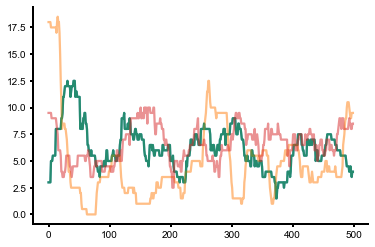

In [206]:
celln = 19
test_r = (np.convolve(test_nsp_all[da][:,celln], np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']))[params['bin_length']:-params['bin_length']]
shuff_1 = (np.convolve(test_shuff_nsp_all[da][:,celln], np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']))[params['bin_length']:-params['bin_length']]
shuff_2 = (np.convolve(shuffle(test_shuff_nsp_all[da][:,celln],random_state=42), np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']))[params['bin_length']:-params['bin_length']]
shuff_test = Shuff_data[date_ani2[da]]['actual_smooth'][:,celln]
plt.plot(shuff_test[3500:4000])
plt.plot(test_r[3500:4000],alpha=.5)
plt.plot(shuff_1[3500:4000],alpha=.5)
plt.plot(shuff_2[3500:4000],alpha=.5)

np.corrcoef(shuff_test,shuff_1)[0,1],np.corrcoef(test_r,shuff_1)[0, 1],np.corrcoef(test_r,shuff_2)[0, 1]
# plt.plot(test_shuff_nsp_all[da][:,0],alpha=.5)

# plt.plot(shuffle(test_shuff_nsp_all[da][:,0],random_state=42))

(array([ 2.,  0.,  0.,  0.,  1.,  2.,  1.,  4.,  5., 13., 21., 15., 23.,
        27., 28., 35., 34., 18., 15.,  7.,  6.,  6.,  2.,  0.,  1.]),
 array([-0.20330413, -0.18899721, -0.17469029, -0.16038338, -0.14607646,
        -0.13176954, -0.11746263, -0.10315571, -0.0888488 , -0.07454188,
        -0.06023496, -0.04592805, -0.03162113, -0.01731421, -0.0030073 ,
         0.01129962,  0.02560654,  0.03991345,  0.05422037,  0.06852728,
         0.0828342 ,  0.09714112,  0.11144803,  0.12575495,  0.14006187,
         0.15436878]),
 <BarContainer object of 25 artists>)

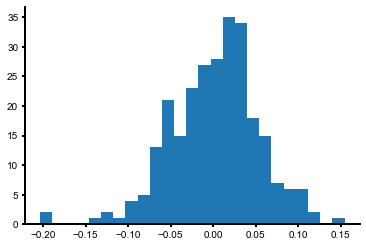

In [208]:
plt.hist(shuff_Vis,bins=25)


In [32]:
Shuff_data[date_ani2[da]].keys()

dict_keys(['actual_meanfr', 'actual_smooth', 'actual_HF_smooth', 'pos_pred_smooth', 'pos_vloss_all', 'pos_vloss_trace', 'pos_moveW', 'pos_cc_test', 'pos_r2_test', 'vis_pred_smooth', 'vis_vloss_all', 'vis_vloss_trace', 'vis_loss_regcv', 'vis_rf_up', 'vis_rf_all', 'vis_cc_test', 'vis_r2_test', 'add_pred_smooth', 'add_vloss_all', 'add_vloss_trace', 'add_moveW', 'add_cc_test', 'add_r2_test', 'mul_pred_smooth', 'mul_vloss_all', 'mul_vloss_trace', 'mul_moveW', 'mul_cc_test', 'mul_r2_test', 'HF_pred_smooth', 'HF_vloss_all', 'HF_vloss_trace', 'HF_loss_regcv', 'HF_rf_up', 'HF_rf_all', 'HF_cc_test', 'HF_r2_test', 'HF_meanfr', 'HF_FMHF_r2'])

In [48]:
shuff_Mot = np.hstack([Shuff_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
shuff_Vis = np.hstack([Shuff_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
shuff_Add = np.hstack([Shuff_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
shuff_Mul = np.hstack([Shuff_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
shuff_HF = np.hstack([Shuff_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
vals_HF = np.hstack([All_data[date_ani2[da]]['HF_cc_test'] for da in range(len(dates_all))])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]

##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
# np.sum(vals_Mot>vals_Vis),vals_Vis.shape[0],np.sum(vals_Mot<vals_Vis),vals_Vis.shape[0]
# plt.hist(vals_Add,bins=25)

In [53]:
np.nanmean(shuff_Vis),2*np.nanstd(shuff_Vis), np.nanmax(shuff_Vis), np.nanmean(vals_Vis)

(-0.002437931739291145,
 0.10973879751585543,
 0.1737472946354336,
 0.3059340050322572)

(array([ 3., 11., 17., 35., 44., 46., 25., 17.,  7.,  3.]),
 array([-0.09512667, -0.01280062,  0.06952544,  0.15185149,  0.23417755,
         0.31650361,  0.39882966,  0.48115572,  0.56348178,  0.64580783,
         0.72813389]),
 <BarContainer object of 10 artists>)

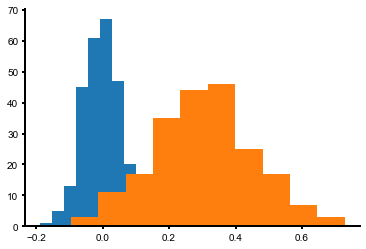

In [37]:
plt.hist(shuff_Vis)
plt.hist(vals_Vis)
# plt.hist(shuff_HF)

In [51]:
np.nanstd(shuff_HF),np.nanmax(shuff_HF)

(0.08167097710959037, 0.19894640066573108)

(array([ 6., 10., 21., 28., 50., 58., 43., 27., 11.,  5.]),
 array([-0.22138286, -0.17934993, -0.137317  , -0.09528408, -0.05325115,
        -0.01121823,  0.0308147 ,  0.07284762,  0.11488055,  0.15691348,
         0.1989464 ]),
 <BarContainer object of 10 artists>)

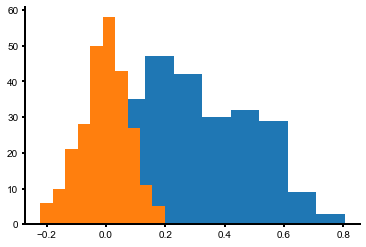

In [49]:
# plt.hist(shuff_Vis)
plt.hist(vals_HF)
plt.hist(shuff_HF)

In [ ]:
# Bar plots of fraction above .2 (max) 

In [30]:
shuff_Vis.shape,(shuff_Mul-shuff_Add).shape

((268,), (268,))

(-0.2, 0.8)

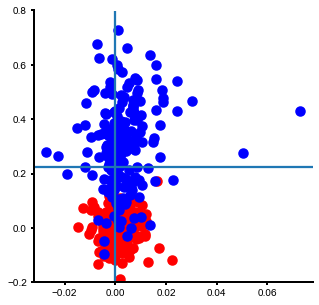

In [29]:
# plt.hist(vals_Vis,bins=25)
# plt.hist(vals_Add,bins=25)
# plt.hist(vals_Mul,bins=25)
fig, axs = plt.subplots(figsize=(5,5))
ax = axs
ax.scatter((shuff_Mul-shuff_Add),shuff_Vis,c='r')
ax.scatter((vals_Mul-vals_Add),vals_Vis,c='b')
ax.axhline(y=np.sqrt(.05))
ax.axvline(x=0)
ax.set_ylim([-.2,.8])

0.22360679774997896

In [62]:
celln = 52#106
modN = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs0a = np.array([fig.add_subplot(gs00[0,m]) for m in range(5)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 0
ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c='k',zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)


modeln = 2
ax = axs0a[1]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c='k',zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

# fig.savefig(paper_fig_dir/'Tuning_Curve_Cell52_101521_cc.pdf', facecolor='white', transparent=True, bbox_inches='tight')


IndexError: index 52 is out of bounds for axis 1 with size 52

## % stats 

In [45]:
from scipy.stats import ttest_rel

Paired T test for Shifter on vs off

In [46]:
#### across all cells
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_VisNoSh = np.hstack([NoSh_data[date_ani2[da]]['VisNoSh_cc_test'] for da in range(len(dates_all))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))
vis_th = r2_all[1] > .05
ttest_rel(r2_all[0,vis_th],r2_all[1,vis_th])

Ttest_relResult(statistic=nan, pvalue=nan)

In [47]:
#### Average within session then t-test across sessions
vals_Vis=[]
vals_VisNoSh=[]
for da in range(len(dates_all)):
    vals_Vis.append(np.nanmean(All_data[date_ani2[da]]['vis_cc_test']))
    vals_VisNoSh.append(np.nanmean(NoSh_data[date_ani2[da]]['VisNoSh_cc_test']))

vals_Vis=np.array(vals_Vis)
vals_VisNoSh=np.array(vals_VisNoSh)

ttest_rel(vals_Vis,vals_VisNoSh)

Ttest_relResult(statistic=4.889345226182695, pvalue=0.016364344509341818)

### Standard Deviation of positional information

In [48]:
np.round(np.nanstd(model_move_FM,axis=0),decimals=1),np.round(np.nanstd(model_move_HF,axis=0),decimals=1)

(array([15.3, 16.2, 21.8, 16.7]), array([10. , 11.1,  0. ,  0. ]))

In [49]:
np.sum(np.abs(model_move_FM[:,0])<15)/(model_move_FM.shape[0])

0.6717352415026834

### number of units increased with joint fit

In [50]:
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])

np.sum(vals_Mot>vals_Vis),vals_Vis.shape[0],np.sum(vals_Mot<vals_Vis),vals_Vis.shape[0]

(78, 268, 189, 268)

In [51]:
np.mean(vals_Vis[vals_Vis>.05]), np.nanmean(vals_Vis), np.nanmax(vals_Vis)

(0.3227173184017243, 0.30483514259933325, 0.7414819277568392)

In [52]:
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]

In [53]:
vals_joint = np.stack((vals_Add,vals_Mul))
vals_increased = np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]
# np.mean(vals_increased)
np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]

array([1.48549685e-01, 1.80528703e-01, 6.43985417e-02, 7.56869000e-02,
       5.64005037e-02, 5.65023327e-02, 1.16357136e-02, 6.74445660e-04,
       1.44305568e-02, 6.80545489e-02, 1.62344807e-02, 4.99627381e-02,
       4.59581661e-03, 6.85051912e-02, 6.68464175e-02, 8.48089372e-02,
       5.45761856e-02, 9.56111574e-03, 1.61850113e-01, 1.16891338e-01,
       7.55562876e-03, 1.71225404e-02, 6.07292960e-02, 1.72931555e-02,
       6.83904715e-02, 9.89904243e-03, 3.23627885e-02, 9.60876780e-02,
       5.67450908e-02, 1.27390753e-03, 5.87215958e-02, 1.26355390e-01,
       3.76780334e-02, 8.91643973e-02, 2.63617755e-02, 8.34988441e-02,
       1.44321405e-02, 1.34214119e-02, 5.77878154e-02, 2.27845416e-02,
       2.16852986e-02, 1.33216604e-01, 7.70987254e-03, 4.52384012e-03,
       2.97608037e-02, 5.05471595e-02, 6.42648014e-02, 5.39970827e-04,
       8.85987557e-02, 1.81289322e-02, 1.20448300e-01, 8.66142893e-02,
       1.95019236e-02, 4.00732143e-02, 1.91884898e-01, 5.95349836e-02,
      

T-test: Add vs Mul

In [54]:
from scipy.stats import ttest_1samp

In [55]:
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]

In [56]:
ttest_1samp((vals_Mul-vals_Add),popmean=0)

Ttest_1sampResult(statistic=4.247999288332347, pvalue=3.345290510449086e-05)

In [57]:
avg_diff = []
avg_add=[]
avg_mul=[]
for da in range(len(dates_all)):
    vM = All_data[date_ani2[da]]['mul_cc_test']
    vV = All_data[date_ani2[da]]['vis_cc_test']
    vA = All_data[date_ani2[da]]['add_cc_test']
    v_th = ((vA>vV) | (vM>vV)) & (vV>.05) # & (vals_Mul>vals_Vis)
    diff = vM[v_th]-vA[v_th]
    avg_add.append(np.nanmean(vA[v_th]))
    avg_mul.append(np.nanmean(vM[v_th]))
    avg_diff.append(np.nanmean(diff))
    print(np.nanmean(diff))
ttest_1samp(avg_diff,popmean=0)

0.003322334757717805
0.00391217654730457
0.0017603700346460322
0.0022839717253598105


Ttest_1sampResult(statistic=5.78052528275586, pvalue=0.010295590620100147)

In [58]:
ttest_rel(vals_Add,vals_Mul)
ttest_rel(avg_add,avg_mul)

Ttest_relResult(statistic=-5.78052528275589, pvalue=0.010295590620100005)

In [59]:
np.argmax(vals_Add[vals_Add<vals_Mul]),vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])]

(11, 0.7368328944367671)

In [60]:
np.nanargmax(vals_Add-vals_Mul),vals_Add[92],vals_Mul[92]

(92, 0.3383209096306267, 0.31107537315709555)

In [61]:
np.where(vals_Add==vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])])

(array([17]),)

In [ ]:
#### 

# Supplementary Figures

#### Shifter Matricies

In [120]:
da = 0
fontsize=10
args['date_ani'] = dates_all[da]
params,_,_ = load_params(0,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'

save_datafile = save_dir_fm/'GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'
GLM_CV = ioh5.load(save_datafile)

best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))

##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_dir'] / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)


Done Loading Unaligned data
Tot_units: (128,)


/tmp/ipykernel_534275/3904998252.py:12: RuntimeWarning: Mean of empty slice
  best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))


/tmp/ipykernel_534275/2073312972.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


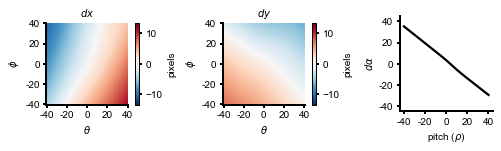

In [143]:
fontsize = 10

fig = plt.figure(constrained_layout=False, figsize=(8,5))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.9,hspace=0)
# gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,:3], wspace=.1,hspace=0)
# gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,3:6], wspace=.1,hspace=.1)
# gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,6:], wspace=.1,hspace=.1)

# gs01a = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.2)
# gs02a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)
# gs03a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0[0,0])])#,fig.add_subplot(gs01[0,0]),fig.add_subplot(gs01[1,1])])
axs2a = np.array([fig.add_subplot(gs0[0,1])])#,fig.add_subplot(gs02[1,0]),fig.add_subplot(gs02[1,1])])
axs3a = np.array([fig.add_subplot(gs0[0,2])])#,fig.add_subplot(gs03[1,0]),fig.add_subplot(gs03[1,1])])



shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
# for n in range(2):
ax = axs1a[0]
n=0
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs2a[0]
n = 1
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs3a[0]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'pitch ($\rho$)',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.axis('square')
ax.set_ylim(-45, 45)


plt.tight_layout()
fig.savefig(paper_fig_dir/'FigureS1.pdf', facecolor='white', transparent=True, bbox_inches='tight')


#### SimRF 

In [83]:
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
SimRF_GLM_file = '/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
GLM_Data = ioh5.load(SimRF_GLM_file)
SimRF_data = ioh5.load(SimRF_file)
RF_Sim = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0], 1,)+(30,40))
Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(Sim_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])


Text(0, 0.5, 'sp/sec')

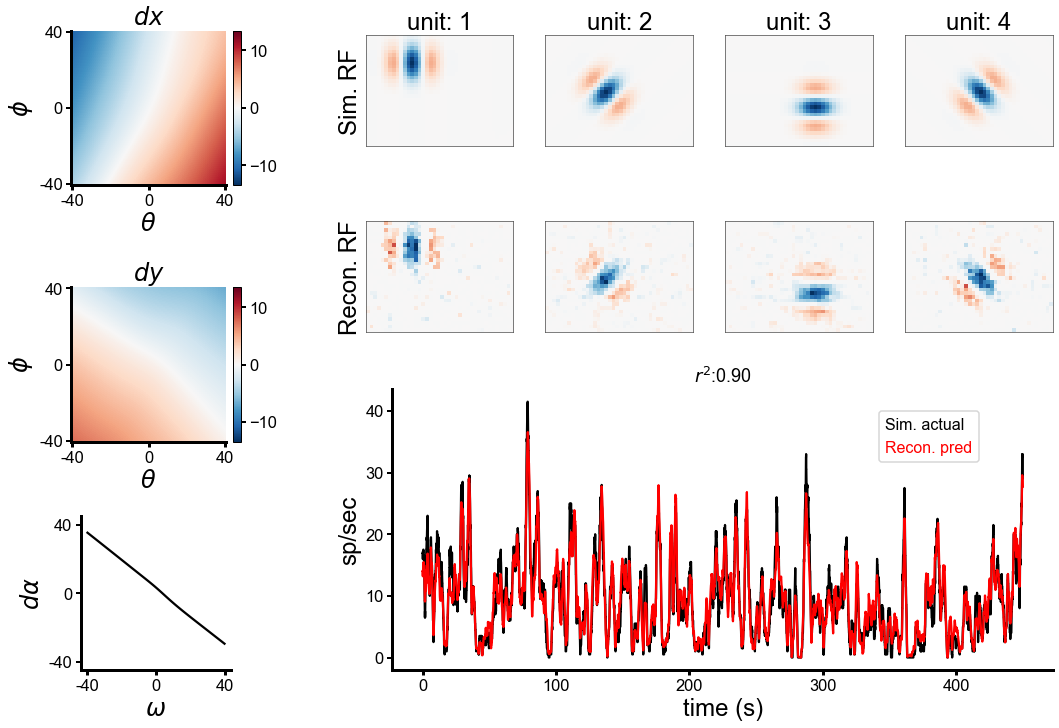

In [84]:
fig1 = plt.figure(constrained_layout=True, figsize=(15,10))
gs0 = fig1.add_gridspec(nrows=2, ncols=3, wspace=.6, hspace=.2)

gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,0],wspace=1,hspace=.1)
axs1 = np.array([fig1.add_subplot(gs01[n,m]) for n in range(3) for m in range(1)]).reshape(3)

shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,40)
ticklabels=np.arange(-40,50,40)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(2):
    ax = axs1[n]
    im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    cbar1.outline.set_linewidth(1)
    # cbar1.set_label(cbar_label[n],fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\theta$',fontsize=fontsize)
    ax.set_ylabel(r'$\phi$',fontsize=fontsize)
    ax.set_title(shift_titles[n],fontsize=fontsize)
ax = axs1[2]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'$\omega$',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,0,40])
ax.set_yticklabels([-40,0,40])
ax.axis('square')
ax.set_ylim(-45, 45)


cells = [0,25,62,43]
gs02 = gridspec.GridSpecFromSubplotSpec(2, len(cells), subplot_spec=gs0[:1,1:],wspace=.1,hspace=.05)
axs2 = np.array([fig1.add_subplot(gs02[n,m]) for n in range(2) for m in range(len(cells))]).reshape(2,len(cells))
for n, cell in enumerate(cells):
    ax = axs2[0,n]
    crange2 = np.max(np.abs(SimRF_data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax = axs2[1,n]
    crange1 = np.max(np.abs(RF_Sim[cell]))
    im2 = ax.imshow(RF_Sim[cell,0],'RdBu_r', vmin=-crange1, vmax=crange1)


    # crange2 = np.max(np.abs(RF_all[0,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im2 = axs1[0,n].imshow(RF_all[0,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    # crange1 = np.max(np.abs(RF_all[1,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im1 = axs1[1,n].imshow(RF_all[1,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs2[0,n].set_title('unit: {}'.format(n+1), fontsize=fontsize)

axs2[1,0].set_ylabel('Recon. RF', fontsize=fontsize)
axs2[0,0].set_ylabel('Sim. RF', fontsize=fontsize)
for ax in axs2.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   
# cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange1, crange1])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)


gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,1:],wspace=.1,hspace=.1)
axs3 = np.array([fig1.add_subplot(gs03[0,:])])

cell = 62
ax = axs3[0]
pred_time = (np.arange(Sim_act_smooth.shape[1])*params['model_dt'])
ax.plot(pred_time,Sim_act_smooth[cell],c='k', label='Sim. actual')
ax.plot(pred_time,Sim_smooth[:,cell],c='r', label='Recon. pred')
ax.legend(labelcolor='linecolor', fontsize=16, handlelength=0, handletextpad=0,loc='upper right',ncol=1, bbox_to_anchor=(.9, .95))
ax.set_title('$r^2$:{:.02f}'.format(Sim_r2[cell]))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

In [ ]:
#Histogram 
# Simulated shifter network data. 

### Figure S2

In [55]:
da = 2
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (56,)


In [133]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))


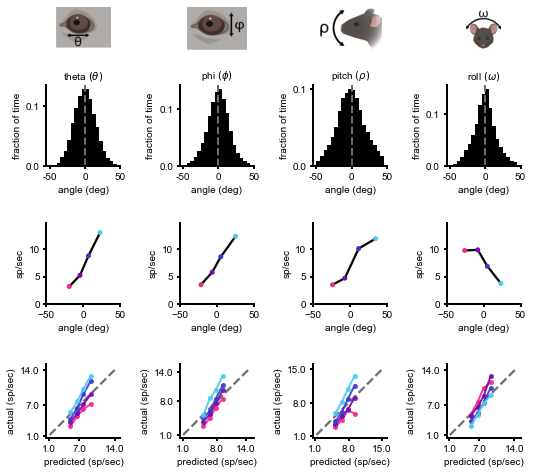

In [60]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']

celln = 1#16 #106

modN = 0
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]]['vis_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]]['vis_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))


fig = plt.figure(constrained_layout=False, figsize=(8.5,8))
gs0 = gridspec.GridSpec(ncols=4, nrows=6, figure=fig, wspace=.3, hspace=.8)

##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
gs00b = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs0[1:,:],wspace=.8,hspace=.7)
axs0aa = np.array([fig.add_subplot(gs00[0,m]) for m in range(4)])
axs0a = np.array([fig.add_subplot(gs00b[0,m]) for m in range(4)])
axs0b = np.array([fig.add_subplot(gs00b[1,m]) for m in range(4)])
axs0c = np.array([fig.add_subplot(gs00b[2,m]) for m in range(4)])

for modeln in np.arange(len(titles)):
    ax=axs0aa[modeln]
    ax.imshow(icons[modeln])
    ax.axis('off')


hbins=5
xticks = [-50, 0, 50]
yticks = [0,.1]
for modeln in np.arange(len(titles)):
    ax=axs0a[modeln]
    count,edges = np.histogram(model_move_FM[:,modeln],bins=np.arange(-50,50,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/(model_move_FM.shape[0]),color='k',width=hbins, alpha=1)
    ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
    ax.set_title(titles[modeln],fontsize=fontsize)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('fraction of time',fontsize=fontsize)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)


dwidth = .1
for modeln in np.arange(0,len(titles)):
    ax = axs0b[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
    stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

    edge_mids = np.quantile(metric,spk_percentile2)#
    # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
    ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=1,c='k',zorder=0,markeredgewidth=0)
    ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
    ax.set_xlim(-xlim_range,xlim_range)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('sp/sec',fontsize=fontsize)
    # ax.set_title(titles[modeln],fontsize=fontsize)
    # ax.axis('square')
    ax.set_ylim(0,top_yaxs)

for modeln in range(len(titles)):
    ax = axs0c[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
        ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
    # ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
    ax.set_xticks([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])]) #np.arange(lims[0],lims[1],int(lims[1]/2)))
    ax.set_yticks([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])]) #np.arange(lims[0],lims[1],int(lims[1]/2)))
    ax.set_xticklabels([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])])# np.round(np.arange(lims[0],lims[1],int(lims[1]/2))))
    ax.set_yticklabels([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])])# np.round(np.arange(lims[0],lims[1],int(lims[1]/2))))
    ax.axis('square')
    # ax.set(xlim=lims, ylim=lims)
    # ax.set_ylim(bottom=0)
    # ax.set_xlim(left=0)
fig.savefig(paper_fig_dir/'FigureS2.pdf', transparent=True, bbox_inches='tight')


In [61]:
lim_max

14.572481194055733

### Video S1

In [3]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

# data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

# ##### Set Train Test Splits #####
# Kfold = 0
# train_idx = train_idx_list[Kfold]
# test_idx = test_idx_list[Kfold]
# data = load_Kfold_data(data,train_idx,test_idx,params)

data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [5]:
data['model_vid_sm'].shape

(30272, 60, 80)

In [4]:
date_ani = '070921/J553RT'
stim_type = 'fm1'
fmimu_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*imu.nc'))[0]
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*REYE.nc'))[0]
world_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*world.nc'))[0]
ephys_file = params['save_dir']/'RawEphysData.h5'

ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']

imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
eyeT = eye_data.timestamps  - ephys_data['t0'].iloc[0]

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

world_data = xr.open_dataset(file_dict['world'])
world_vid_raw = np.uint8(world_data['WORLD_video'])
worldT = world_data.timestamps.copy()
worldT = worldT - ephys_data['t0'].iloc[0]

if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
if worldT[0]<-600:
    worldT = worldT + 8*60*60
accT2 = accT.sample.data - ephys_data['t0'].iloc[0]

# isfast = np.diff(eyeT)<=0.05
# isslow = sorted(list(set(chain.from_iterable([list(range(int(i)-3,int(i)+4)) for i in np.where(isfast==False)[0]]))))
# th[isslow] = np.nan
# phi[isslow] = np.nan


In [5]:
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).rglob('*REYEdeinter.avi'))[0]

cap = cv2.VideoCapture(eye_file.as_posix())
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = int(cap.get(cv2.CAP_PROP_FPS)) # float `fps`
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # float `total_frame_in_the_video` (should not be applicable for camera)
sf=2
eye_vid = np.zeros((int(total_frames),140, 175))
for t in tqdm(range(total_frames)):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray,(int(width//sf),int(height//sf)))
    eye_vid[t] = gray[100:,75:250]

cap.release()

  0%|          | 0/147790 [00:00<?, ?it/s]

In [6]:

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

In [12]:
worldT0

46

In [9]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))

probe = image.imread(list(paper_fig_dir.glob('*probe.png'))[0])


(1497.0, 1513.0)

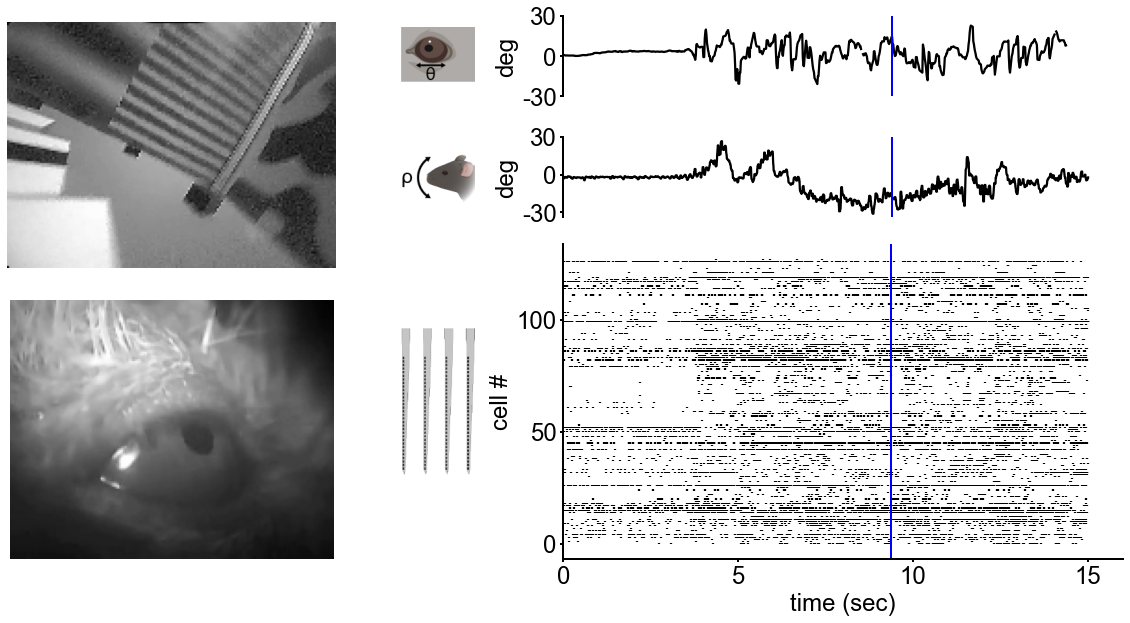

In [10]:
dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])


wt=500
fontsize=24
t=worldTmin + wt
tt = worldT[t].data
eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
cell_t = np.nanargmin(np.abs(cellT-(tt)))

fig = plt.figure(constrained_layout=False, figsize=(20,10))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
axs1c = np.array([fig.add_subplot(gs02[0,1:])])

#### World/Eye Camera
ax = axs1a[0]
ax.imshow(world_vid_raw[t],cmap='gray')
ax.axis('off')
ax = axs1a[1]
ax.imshow(eye_vid[eye_interp_t],cmap='gray')
ax.axis('off')

##### Theta #####
ax = axs1bb[0]
ax.imshow(icons[0])
ax.axis('off')
ax = axs1b[0]
ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Phi #####
# ax = axs1bb[1]
# ax.imshow(icons[1])
# ax.axis('off')
# ax = axs1b[1]
# ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Pitch #####
ax = axs1bb[1]
ax.imshow(icons[2])
ax.axis('off')
ax = axs1b[1]
ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


##### Roll #####
# ax = axs1bb[3]
# ax.imshow(icons[3])
# ax.axis('off')
# ax = axs1b[3]
# ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

for ax, modeln in zip(axs1b,range(len(titles))):
    ax.set_yticks([-30,0,30])
    ax.set_yticklabels([-30,0,30], fontsize=fontsize)
    ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
    # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(Tmin,Tmax+1)


ax = axs1cc[0]
ax.imshow(probe)
ax.axis('off')
ax = axs1c[0]
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
ax.set_yticks([0,50,100])
ax.set_yticklabels([0,50,100], fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=cellT[cell_t],c='b',lw=2)
ax.set_xlim(Tmin,Tmax+1)

In [11]:
@ray.remote
def make_plt_im(wt, worldTmin,worldTmax,worldT,eyeTmin,eyeTmax,eyeT,eye_vid,accT,moveTmin,moveTmax,world_vid_raw,th,phi,gpitch,groll,cell_spikes, Tmin,Tmax,dT,dT_all, pbar: ActorHandle,):  #
    t=worldTmin + wt
    tt = worldT[t].data
    eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
    acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
    cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
    cell_t = np.nanargmin(np.abs(cellT-(tt)))

    fig = plt.figure(constrained_layout=False, figsize=(20,10))
    gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
    gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
    gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

    gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

    axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
    axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
    axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
    axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
    axs1c = np.array([fig.add_subplot(gs02[0,1:])])

    #### World/Eye Camera
    ax = axs1a[0]
    ax.imshow(world_vid_raw[t],cmap='gray')
    ax.axis('off')
    ax = axs1a[1]
    ax.imshow(eye_vid[eye_interp_t],cmap='gray')
    ax.axis('off')

    ##### Theta #####
    ax = axs1bb[0]
    ax.imshow(icons[0])
    ax.axis('off')
    ax = axs1b[0]
    ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Phi #####
    # ax = axs1bb[1]
    # ax.imshow(icons[1])
    # ax.axis('off')
    # ax = axs1b[1]
    # ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Pitch #####
    ax = axs1bb[1]
    ax.imshow(icons[2])
    ax.axis('off')
    ax = axs1b[1]
    ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


    ##### Roll #####
    # ax = axs1bb[3]
    # ax.imshow(icons[3])
    # ax.axis('off')
    # ax = axs1b[3]
    # ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

    for ax, modeln in zip(axs1b,range(len(titles))):
        ax.set_yticks([-30,0,30])
        ax.set_yticklabels([-30,0,30], fontsize=fontsize)
        ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
        # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(Tmin,Tmax+1)


    ax = axs1cc[0]
    ax.imshow(probe)
    ax.axis('off')
    ax = axs1c[0]
    ax.eventplot(cell_spikes,color='k',linelengths=.5)
    ax.set_xlabel('time (sec)',fontsize=fontsize)
    ax.set_ylabel('cell #',fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
    ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels([0,50,100], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=cellT[cell_t],c='b',lw=2)
    ax.set_xlim(Tmin,Tmax+1)

    plt.show()
    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [15]:
mpl.use('agg')

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(worldTmax-worldTmin)
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
worldT_r = ray.put(worldT.data)
eyeT_r = ray.put(eyeT)
accT_r = ray.put(accT)
world_vid_raw_r = ray.put(world_vid_raw)
th_r = ray.put(th)
phi_r = ray.put(phi)
gpitch_r = ray.put(gpitch)
groll_r = ray.put(groll)
cell_spikes_r = ray.put(cell_spikes)
eye_vid_r = ray.put(eye_vid)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t,worldTmin,worldTmax,worldT_r,eyeTmin,eyeTmax,eyeT_r,eye_vid_r,accT_r,moveTmin,moveTmax,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r, Tmin,Tmax,dT,dT_all, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'ExampleData.avi'


vid_name = paper_fig_dir / aniname
FPS = 60
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc('M','J','P','G'), FPS, (images.shape[-2], images.shape[-3])) #cv2.VideoWriter_fourcc(*'mp4v')

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb,worldT_r,eyeT_r,accT_r,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r,eye_vid_r
gc.collect()


  0%|          | 0/785 [00:00<?, ?it/s]

(make_plt_im pid=382024) Figure(2000x1000)
(make_plt_im pid=382037) Figure(2000x1000)
(make_plt_im pid=382031) Figure(2000x1000)
(make_plt_im pid=382017) Figure(2000x1000)
(make_plt_im pid=382016) Figure(2000x1000)
(make_plt_im pid=382034) Figure(2000x1000)
(make_plt_im pid=382020) Figure(2000x1000)
(make_plt_im pid=382029) Figure(2000x1000)
(make_plt_im pid=382028) Figure(2000x1000)
(make_plt_im pid=382014) Figure(2000x1000)
(make_plt_im pid=382010) Figure(2000x1000)
(make_plt_im pid=382022) Figure(2000x1000)
(make_plt_im pid=382026) Figure(2000x1000)
(make_plt_im pid=382025) Figure(2000x1000)
(make_plt_im pid=382015) Figure(2000x1000)
(make_plt_im pid=382023) Figure(2000x1000)
(make_plt_im pid=382012) Figure(2000x1000)
(make_plt_im pid=382039) Figure(2000x1000)
(make_plt_im pid=382021) Figure(2000x1000)
(make_plt_im pid=382011) Figure(2000x1000)
(make_plt_im pid=382038) Figure(2000x1000)
(make_plt_im pid=382040) Figure(2000x1000)
(make_plt_im pid=382032) Figure(2000x1000)
(make_plt_i

(pid=384599) [2022-03-01 14:30:35,928 C 384599 384638] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=384599) *** StackTrace Information ***
(pid=384599)     ray::SpdLogMessage::Flush()
(pid=384599)     ray::RayLog::~RayLog()
(pid=384599)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=384599)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=384599)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=384599)     method_vectorcall_NOARGS
(pid=384599) 


(make_plt_im pid=382018) Figure(2000x1000)
(make_plt_im pid=382037) Figure(2000x1000)
(make_plt_im pid=382031) Figure(2000x1000)
(make_plt_im pid=382020) Figure(2000x1000)
(make_plt_im pid=382029) Figure(2000x1000)
(make_plt_im pid=382017) Figure(2000x1000)
(make_plt_im pid=382024) Figure(2000x1000)
(make_plt_im pid=382034) Figure(2000x1000)
(make_plt_im pid=382028) Figure(2000x1000)
(make_plt_im pid=382030) Figure(2000x1000)
(make_plt_im pid=382016) Figure(2000x1000)
(make_plt_im pid=382025) Figure(2000x1000)
(make_plt_im pid=382022) Figure(2000x1000)
(make_plt_im pid=382026) Figure(2000x1000)
(make_plt_im pid=382011) Figure(2000x1000)
(make_plt_im pid=382014) Figure(2000x1000)
(make_plt_im pid=382015) Figure(2000x1000)
(make_plt_im pid=382012) Figure(2000x1000)
(make_plt_im pid=382040) Figure(2000x1000)
(make_plt_im pid=382021) Figure(2000x1000)
(make_plt_im pid=384576) Figure(2000x1000)
(make_plt_im pid=382010) Figure(2000x1000)
(make_plt_im pid=382038) Figure(2000x1000)
(make_plt_i

  0%|          | 0/785 [00:00<?, ?it/s]

Making Animation ExampleData.avi: 69.56983304023743


19

### Video S2

In [10]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[1]
# args['date_ani'] = '062921/G6HCK1ALTRN'    
# args['date_ani'] = '070921/J553RT'    
# args['date_ani'] = '101521/J559NC'
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=True
args['NoL1'] = True
args['do_norm']=True
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params['downsamp_vid'] = 2
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

ModelList = sorted(list((exp.save_dir.parent.parent / fm_dir / 'GLM_Network').rglob('*_best.h5')))

if args['NoL1'] == True: 
    L1 = 'NoL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('Shifter' in ModelList[n].as_posix())]
else: 
    L1 = 'withL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('VisShifter' in ModelList[n].as_posix())]

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
GLM_Shifter = ioh5.load(ModelList[-1])

Done Loading Unaligned data
Tot_units: (67,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:659: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, LinMix: False, move_features: None, Ncells: 63, train_shifter: True


In [6]:
GLM_Shifter.keys()

dict_keys(['Cell_NN.0.bias', 'Cell_NN.0.weight', 'loss_regcv', 'out_cv', 'pred_cv', 'r2_test', 'shifter_nn.0.bias', 'shifter_nn.0.weight', 'shifter_nn.2.bias', 'shifter_nn.2.weight', 'tloss_trace_all', 'vloss_trace_all'])

In [11]:

##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=50
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)
# model_move[:,-1] = medfilt(model_move[:,-1],7)
ds=4/params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
# ioh5.save(shift_vid_file,model_vid_sm_shift2)
# print(shift_vid_file)

/tmp/ipykernel_478305/1772719770.py:2: RuntimeWarning: Mean of empty slice
  best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))


11


In [12]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Head-centric'.format(t),fontsize=20)
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Retinocentric'.format(t),fontsize=20)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images




In [13]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(1300,1600)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'EyeCorrection_Cosyne.mp4'


vid_name = paper_fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


  0%|          | 0/300 [00:00<?, ?it/s]

(pid=485264) [2022-03-02 20:48:25,264 C 485264 485303] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=485264) *** StackTrace Information ***
(pid=485264)     ray::SpdLogMessage::Flush()
(pid=485264)     ray::RayLog::~RayLog()
(pid=485264)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=485264)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=485264)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=485264)     method_vectorcall_NOARGS
(pid=485264) 


  0%|          | 0/300 [00:00<?, ?it/s]

Making Animation EyeCorrection_Cosyne.mp4: 6.978424787521362


29

# Other Plots

### Comparison of all Plots

In [24]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))


In [24]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Pos','Vis','Add','Mul','HF']
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all = [],[], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag'] = 5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(set(date_ani_dir.rglob(mod_name+'.h5')) - set(date_ani_dir.rglob('*VisNoShifter'+mod_name+'.h5')))))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)



Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [25]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [25]:

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [30]:
save_pdf = True
anglim = 65
fontsize=24
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
pdf_name = paper_fig_dir/ ('MoViAdMuHF_AllCells_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig = plt.figure(constrained_layout=False, figsize=(30,10))
    gs0 = gridspec.GridSpec(nrows=2, ncols=5, figure=fig,wspace=.8,hspace=.3)

    ########## Histograms of R2 ##########
    axs0a = np.array([fig.add_subplot(gs0[0, n]) for n in range(gs0.ncols)])
    axs0b = np.array([fig.add_subplot(gs0[1, n]) for n in range(gs0.ncols)])

    vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_r2_test'] for da in range(len(dates_all))])
    vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
    vals_Add = np.hstack([All_data[date_ani2[da]]['add_r2_test'] for da in range(len(dates_all))])
    vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_r2_test'] for da in range(len(dates_all))])
    vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
    vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])

    r2_all = np.stack((vals_Mot,vals_Vis,vals_Add,vals_Mul,vals_HF))
    hbins=.05
    for n in range(len(mod_titles)):
        ax = axs0a[n]
        count,edges = np.histogram(r2_all[n],bins=np.arange(0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(0,1.2,.2))
        ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
        ax.set_title(mod_titles[n])
        ax.set_xlabel(r'$r^2$')

    ax=axs0b[-1]
    count,edges = np.histogram(np.abs(vals_FMHF),bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('FM_HF_CC')
    ax.set_xlabel('cc')
    ########## Scatter of all R2 ########## 

    tuning_idx = np.where(tuning_sig_all)[0]
    lims = (0, .65)
    crange=500
    ##### Vis vs Mot #####
    ax = axs0b[0]
    # im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
    # ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    # ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    # ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
    # ax.set_yticks(np.arange(0,lims[1],.2))
    # ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.set_ylim(0,lims[1])
    # ax.set_xlim(0,lims[1])
    # ax.set_xticks(np.arange(0,lims[1],.2))
    # ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.axis('equal')
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    ##### Vis vs Add/Mul #####
    cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
    vals_AM = np.max(np.stack((vals_Add,vals_Mul)),axis=0)
    AvM = vals_Add<vals_Mul
    ax = axs0b[1]
    scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    ax.set_ylabel('$r^2$',fontsize=fontsize)
    ax.set_yticks(np.arange(0,lims[1],.2))
    ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.set_ylim(0,lims[1])
    ax.set_xlim(0,lims[1])
    ax.set_xticks(np.arange(0,lims[1],.2))
    ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.axis('equal')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="best")
    legend1.get_texts()[0].set_text('Add') 
    legend1.get_texts()[0].set_color(mod_clrs[2])
    legend1.get_texts()[1].set_text('Mul')
    legend1.get_texts()[1].set_color(mod_clrs[3])

    vloss_Mot = np.hstack([All_data[date_ani2[da]]['pos_vloss_trace'] for da in range(len(dates_all))])
    vloss_Vis = np.hstack([All_data[date_ani2[da]]['vis_vloss_trace'] for da in range(len(dates_all))])
    vloss_Add = np.hstack([All_data[date_ani2[da]]['add_vloss_trace'] for da in range(len(dates_all))])
    vloss_Mul = np.hstack([All_data[date_ani2[da]]['mul_vloss_trace'] for da in range(len(dates_all))])

    # ##### MSE #####
    # diff = vloss_Add-vloss_Mul
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[2]
    # im=ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('MSE: Add-Mul',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.02,.02)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    # ##### R2 Explained Variance #####
    # diff = vals_Mul-vals_Add
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[3]
    # im = ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('R2: Mul-Add',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.075,.075)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    plt.tight_layout()
    pdf.savefig()
    plt.close()
for da in tqdm(np.arange(len(date_ani2))):
    args['date_ani'] = dates_all[da]
    args['free_move'] = True
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    ncells=All_data[date_ani2[da]][mod_titles[0]+'_pred_smooth'].shape[-1]
    for celln in tqdm(np.arange(ncells)):
        predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
        nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
        pred_range = np.quantile(predcell,[.1,.9])
        test_nsp_range = np.quantile(nspcell,[.01,1])
        pred_rangelin = np.quantile(predcell,spike_percentiles)
        xbin_pts = np.quantile(predcell,spk_percentile2)
        stat_bins = len(pred_rangelin)
        fig = plt.figure(constrained_layout=False, figsize=(30,25))
        gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

        ########## Plotting FM/HF RFs ##########
        gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
        axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
        axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

        ax = axs0a[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
        ax.set_title('FM RF')

        ax = axs0a[1]
        ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

        ax = axs0a[2]
        ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

        ax =axs0a[3]
        for modN in range(len(mod_titles)-1):
            ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ########### Head Fixed plots ###########
        ax = axs0b[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.set_title('HF RF')
        ax.axis('off')

        ax = axs0b[1]
        ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

        ax = axs0b[2]
        ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

        ax =axs0b[3]
        ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ######### Position Weights ##########

        w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
        w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
        for modeln in range(len(titles)):
            axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
            axs0a[4].set_xticks(np.arange(0,len(titles)))
            axs0a[4].set_xticklabels(titles)
            axs0a[4].set_ylabel('GLM Weight')
            axs0a[4].set_title('Add Weights')

            axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
            axs0b[4].set_xticks(np.arange(0,len(titles)))
            axs0b[4].set_xticklabels(titles)
            axs0b[4].set_ylabel('GLM Weight')
            axs0b[4].set_title('Mul Weights')



        ########## Fig 4A ########## 
        gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
        axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
        axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

        top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
        traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
        edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        for i,modeln in enumerate(range(len(titles))):
            metric = move_data[params['bin_length']:-params['bin_length'],modeln]
            nranges = np.quantile(metric,quartiles)
            stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
            edge_mids = np.quantile(metric,spk_percentile2)#
            for m in range(len(nranges)-1):
                axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
            axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
            axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
            xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
            axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
            axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
            axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
            axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

            try:
                stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts 
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]
                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
                    axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
                
                lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
                lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
                lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                # axs1b[0,modeln].axis('equal')
                axs1b[0,modeln].set(xlim=lims, ylim=lims)
                # axs1b[0,modeln].set_ylim(bottom=0)
            except:
                print(celln, 'Failed')


        ########## Fig 4B ########## 
        gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
        axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
        axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

        cmap = mpl.colors.ListedColormap(q_clrs)
        ##### Plotting Position Scatter #####
        t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
        dt = int(200/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2[0,0]
        metric = move_data[params['bin_length']:-params['bin_length'],3]
        ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
        ax.set_ylabel(r'$\rho$ (deg)',fontsize=fontsize)
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylim([-anglim,anglim])

        # celln = 18#106
        # da = 0
        # t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
        # dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
        ##### Plotting Firing Rate #####
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2b[0,0]
        zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
        ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
        for modN in range(len(mod_titles)-1):
            ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
                    label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
        ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylabel('sp/sec',fontsize=fontsize)

        Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
        Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
        Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
        Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
        FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_cc'][celln]
        plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,totcelln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
        totcelln = totcelln+1
        # fig.savefig(paper_fig_dir/'Fig4_draft_Cell52_101521.png', facecolor='white', transparent=True, bbox_inches='tight')
        # plt.tight_layout()
        if save_pdf:
            pdf.savefig()
            plt.close()
if save_pdf:
    pdf.close()


<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/ticker.py:633: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
/tmp/ipykernel_144958/1383697130.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  0%|          | 0/5 [00:00<?, ?it/s]

Done Loading Unaligned data
Tot_units: (128,)


  0%|          | 0/108 [00:00<?, ?it/s]

Done Loading Unaligned data
Tot_units: (67,)


  0%|          | 0/63 [00:00<?, ?it/s]

27 Failed
27 Failed
27 Failed
27 Failed
Done Loading Unaligned data
Tot_units: (56,)


  0%|          | 0/45 [00:00<?, ?it/s]

Done Loading Unaligned data
Tot_units: (71,)


  0%|          | 0/52 [00:00<?, ?it/s]

Done Loading Unaligned data
Tot_units: (130,)


  0%|          | 0/77 [00:00<?, ?it/s]

(raylet) ----------------------------------------
(raylet) Exception happened during processing of request from ('100.27.42.243', 28634)
(raylet) Traceback (most recent call last):
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 650, in process_request_thread
(raylet)     self.finish_request(request, client_address)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 360, in finish_request
(raylet)     self.RequestHandlerClass(request, client_address, self)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 720, in __init__
(raylet)     self.handle()
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/wsgiref/simple_server.py", line 118, in handle
(raylet)     self.raw_requestline = self.rfile.readline(65537)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socket.py", line 669, in readinto
(raylet)     return self._sock.recv_into(b)
(raylet

### Position GLM weights

In [36]:
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_r2_test'] for da in range(len(dates_all))])

AddW = np.vstack([All_data[date_ani2[da]]['add_moveW'] for da in range(len(dates_all))])
MulW = np.vstack([All_data[date_ani2[da]]['mul_moveW'] for da in range(len(dates_all))])
MotW = np.vstack([All_data[date_ani2[da]]['pos_moveW'] for da in range(len(dates_all))])

Mot_thresh = vals_Mot>.05

In [37]:
vals_Add2 = (np.abs(AddW)/np.sum(np.abs(AddW),axis=1,keepdims=True))[Mot_thresh]
vals_Mul2 = (np.abs(MulW)/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_Mot2 = (np.abs(MotW)/np.sum(np.abs(MotW),axis=1,keepdims=True))[Mot_thresh]

np.nanmean(vals_Add2,axis=0),np.nanmean(vals_Mul2,axis=0),np.nanmean(vals_Mot2,axis=0)

(array([0.2564982 , 0.2076043 , 0.30169758, 0.23419999], dtype=float32),
 array([0.2533462 , 0.20778878, 0.30145448, 0.23741043], dtype=float32),
 array([0.23285447, 0.19034165, 0.3270445 , 0.24975929], dtype=float32))

In [38]:
MotW2 = pd.DataFrame(MotW,columns=titles)
AddW2 = pd.DataFrame(AddW, columns=titles)
MulW2 = pd.DataFrame(MulW, columns=titles)


def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    mxx = np.max((np.abs(mn),np.abs(mx)))
    points = np.linspace(-mxx, mxx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
                   linestyle='--', linewidth=1.0)


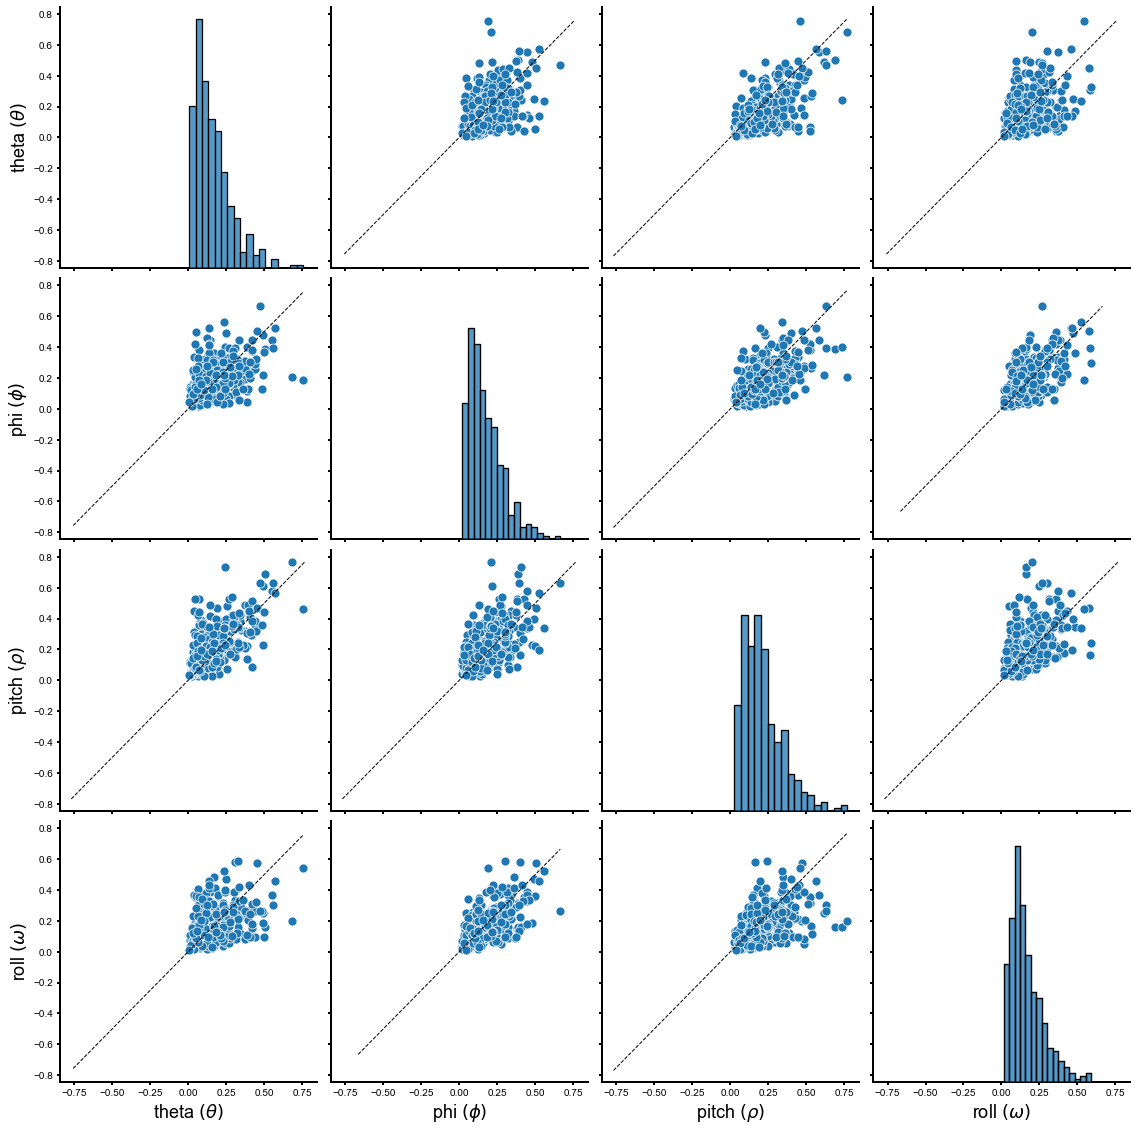

In [39]:

MI_all = pd.DataFrame(tuning_sig_all.squeeze(), columns=titles)
g = sns.pairplot(MI_all, height=4)
g.map_offdiag(plot_unity, levels=4, color=".2")


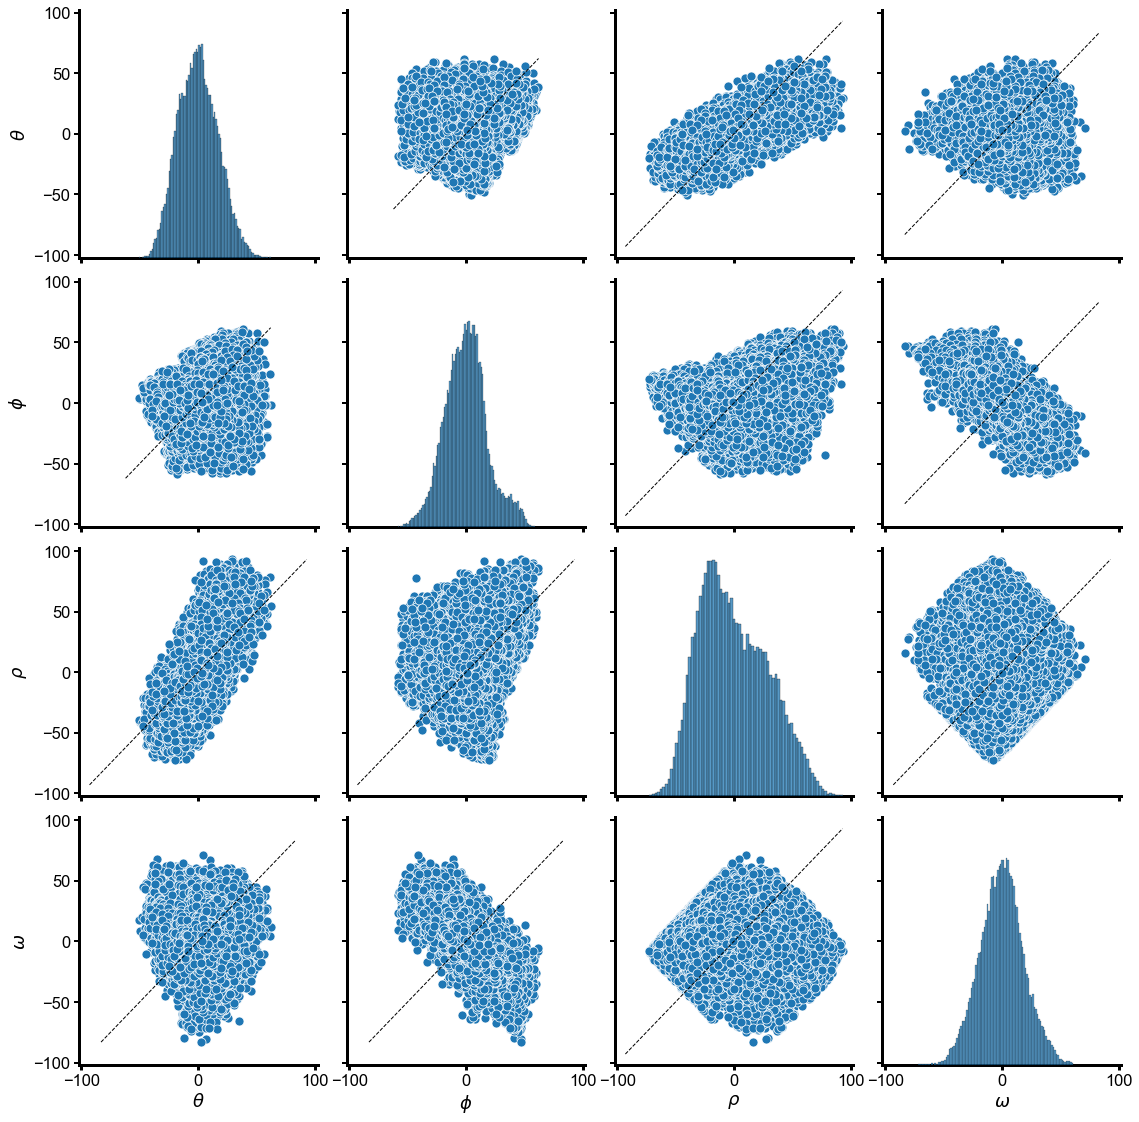

In [177]:
model_move2 = pd.DataFrame(model_move, columns=titles)
g = sns.pairplot(model_move2, height=4)
g.map_offdiag(plot_unity, levels=4, color=".2")


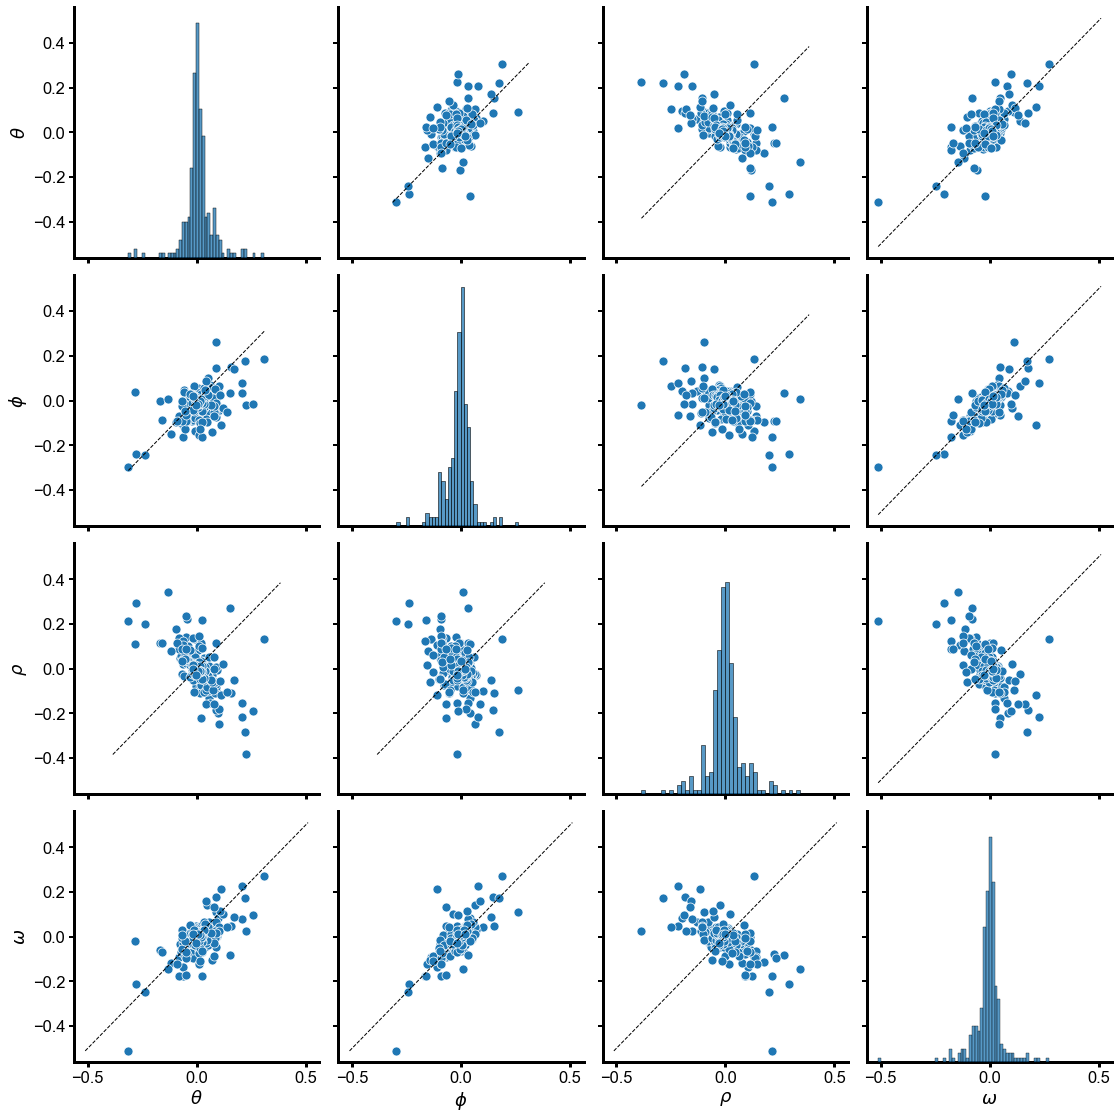

In [18]:
g = sns.pairplot(MotW2, height=4)
g.map_offdiag(plot_unity, levels=4, color=".2")


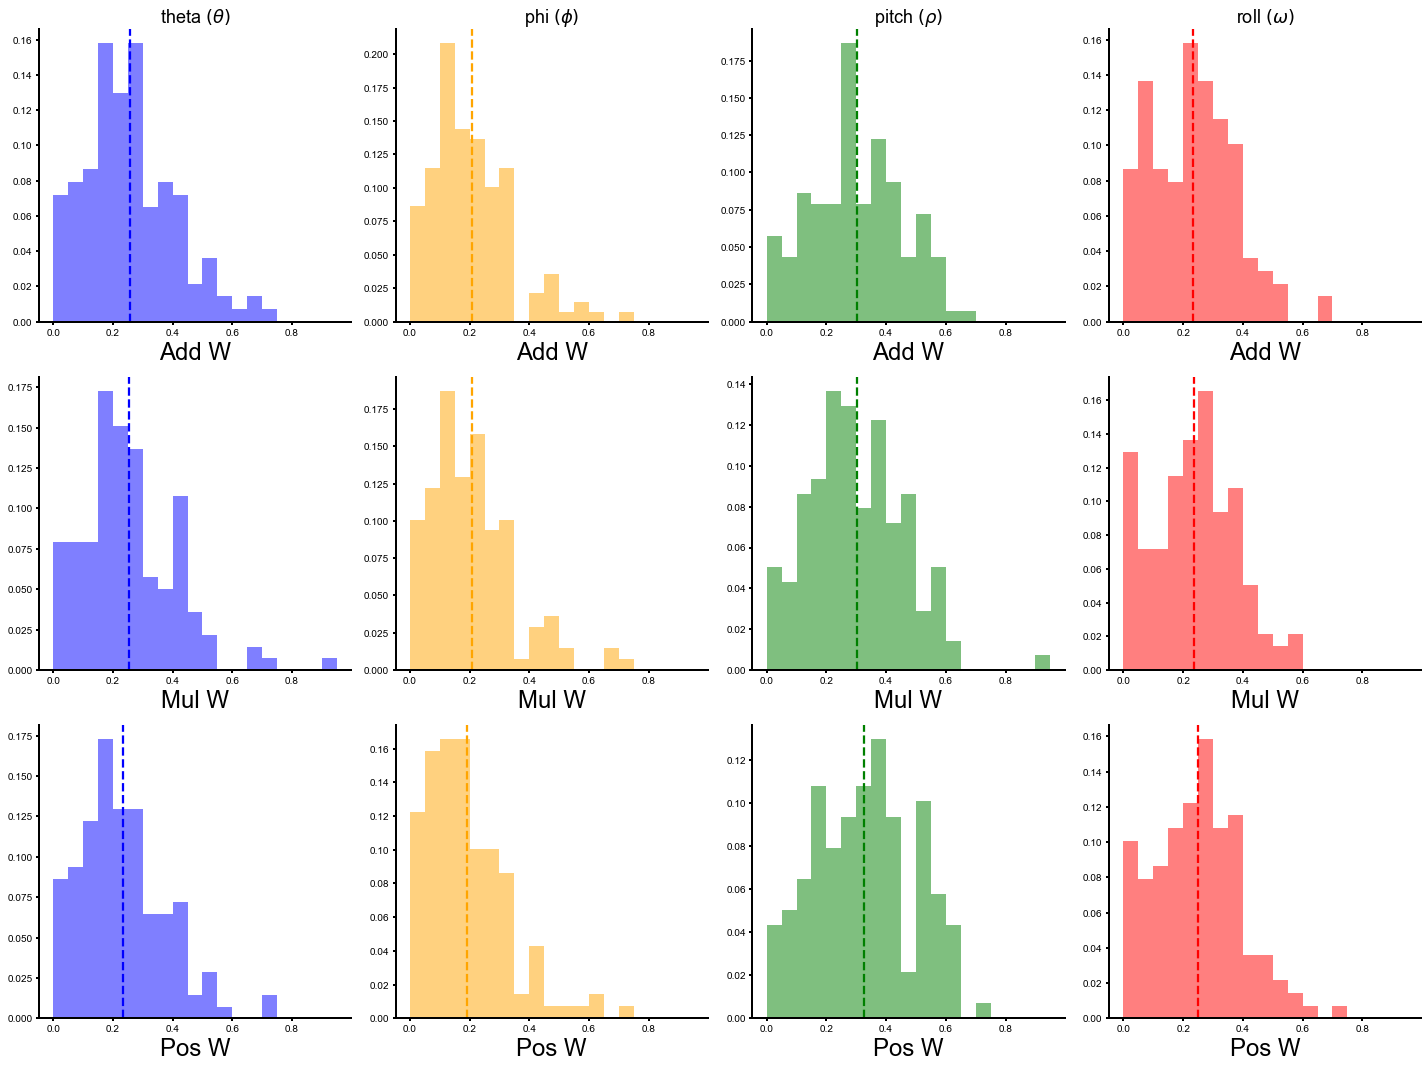

In [40]:
fontsize = 24
fig, axs = plt.subplots(3,4, figsize=(20,15))
move_clrs = ['blue','orange','green','red']
hbins = .05
lim0 = 0
lim1 = 1
dlim = .2
xlab = 'W'
for modeln in range(len(titles)):
    ax = axs[0,modeln]
    count,edges = np.histogram(vals_Add2[:,modeln],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(vals_Add2[:,modeln]),color=move_clrs[modeln],width=hbins, alpha=.5)
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel('Add W',fontsize=fontsize)
    ax.set_title(titles[modeln])
    ax.axvline(x=np.nanmean(vals_Add2[:,modeln]),c=move_clrs[modeln],ls='--')
    

    ax = axs[1,modeln]
    count,edges = np.histogram(vals_Mul2[:,modeln],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(vals_Mul2[:,modeln]),color=move_clrs[modeln],width=hbins, alpha=.5)
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel('Mul W',fontsize=fontsize)
    ax.axvline(x=np.nanmean(vals_Mul2[:,modeln]),c=move_clrs[modeln],ls='--')
    

    ax = axs[2,modeln]
    count,edges = np.histogram(vals_Mot2[:,modeln],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(vals_Mot2[:,modeln]),color=move_clrs[modeln],width=hbins, alpha=.5)
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel('Pos W',fontsize=fontsize)
    ax.axvline(x=np.nanmean(vals_Mot2[:,modeln]),c=move_clrs[modeln],ls='--')
        
plt.tight_layout()
# fig.savefig(paper_fig_dir/'MoveW_propotions.png', facecolor='white', transparent=True, bbox_inches='tight')

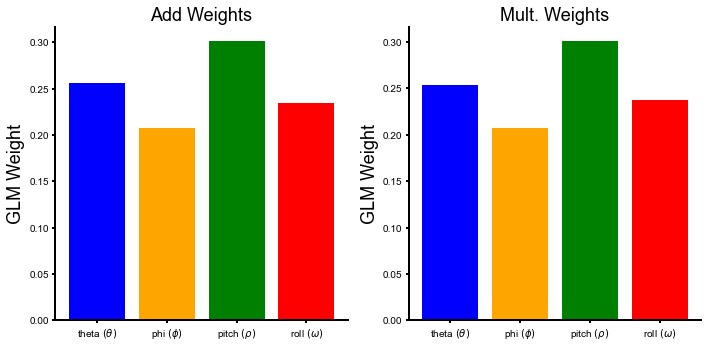

In [41]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
for modeln in range(len(titles)):
    axs[0].bar(modeln, np.nanmean(vals_Add2,axis=0)[modeln], color=move_clrs[modeln])
    axs[0].set_xticks(np.arange(0,len(titles)))
    axs[0].set_xticklabels(titles)
    axs[0].set_ylabel('GLM Weight')
    axs[0].set_title('Add Weights')

    axs[1].bar(modeln, np.nanmean(vals_Mul2,axis=0)[modeln], color=move_clrs[modeln])
    axs[1].set_xticks(np.arange(0,len(titles)))
    axs[1].set_xticklabels(titles)
    axs[1].set_ylabel('GLM Weight')
    axs[1].set_title('Mult. Weights')
plt.tight_layout()

### Single Cell Comparison

In [11]:
All_data[date_ani2[da]].keys()

dict_keys(['actual_meanfr', 'actual_smooth', 'actual_HF_smooth'])

In [19]:
da = -1
args['date_ani'] = dates_all[da]
args['free_move'] = True
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]


Done Loading Unaligned data
Tot_units: (130,)


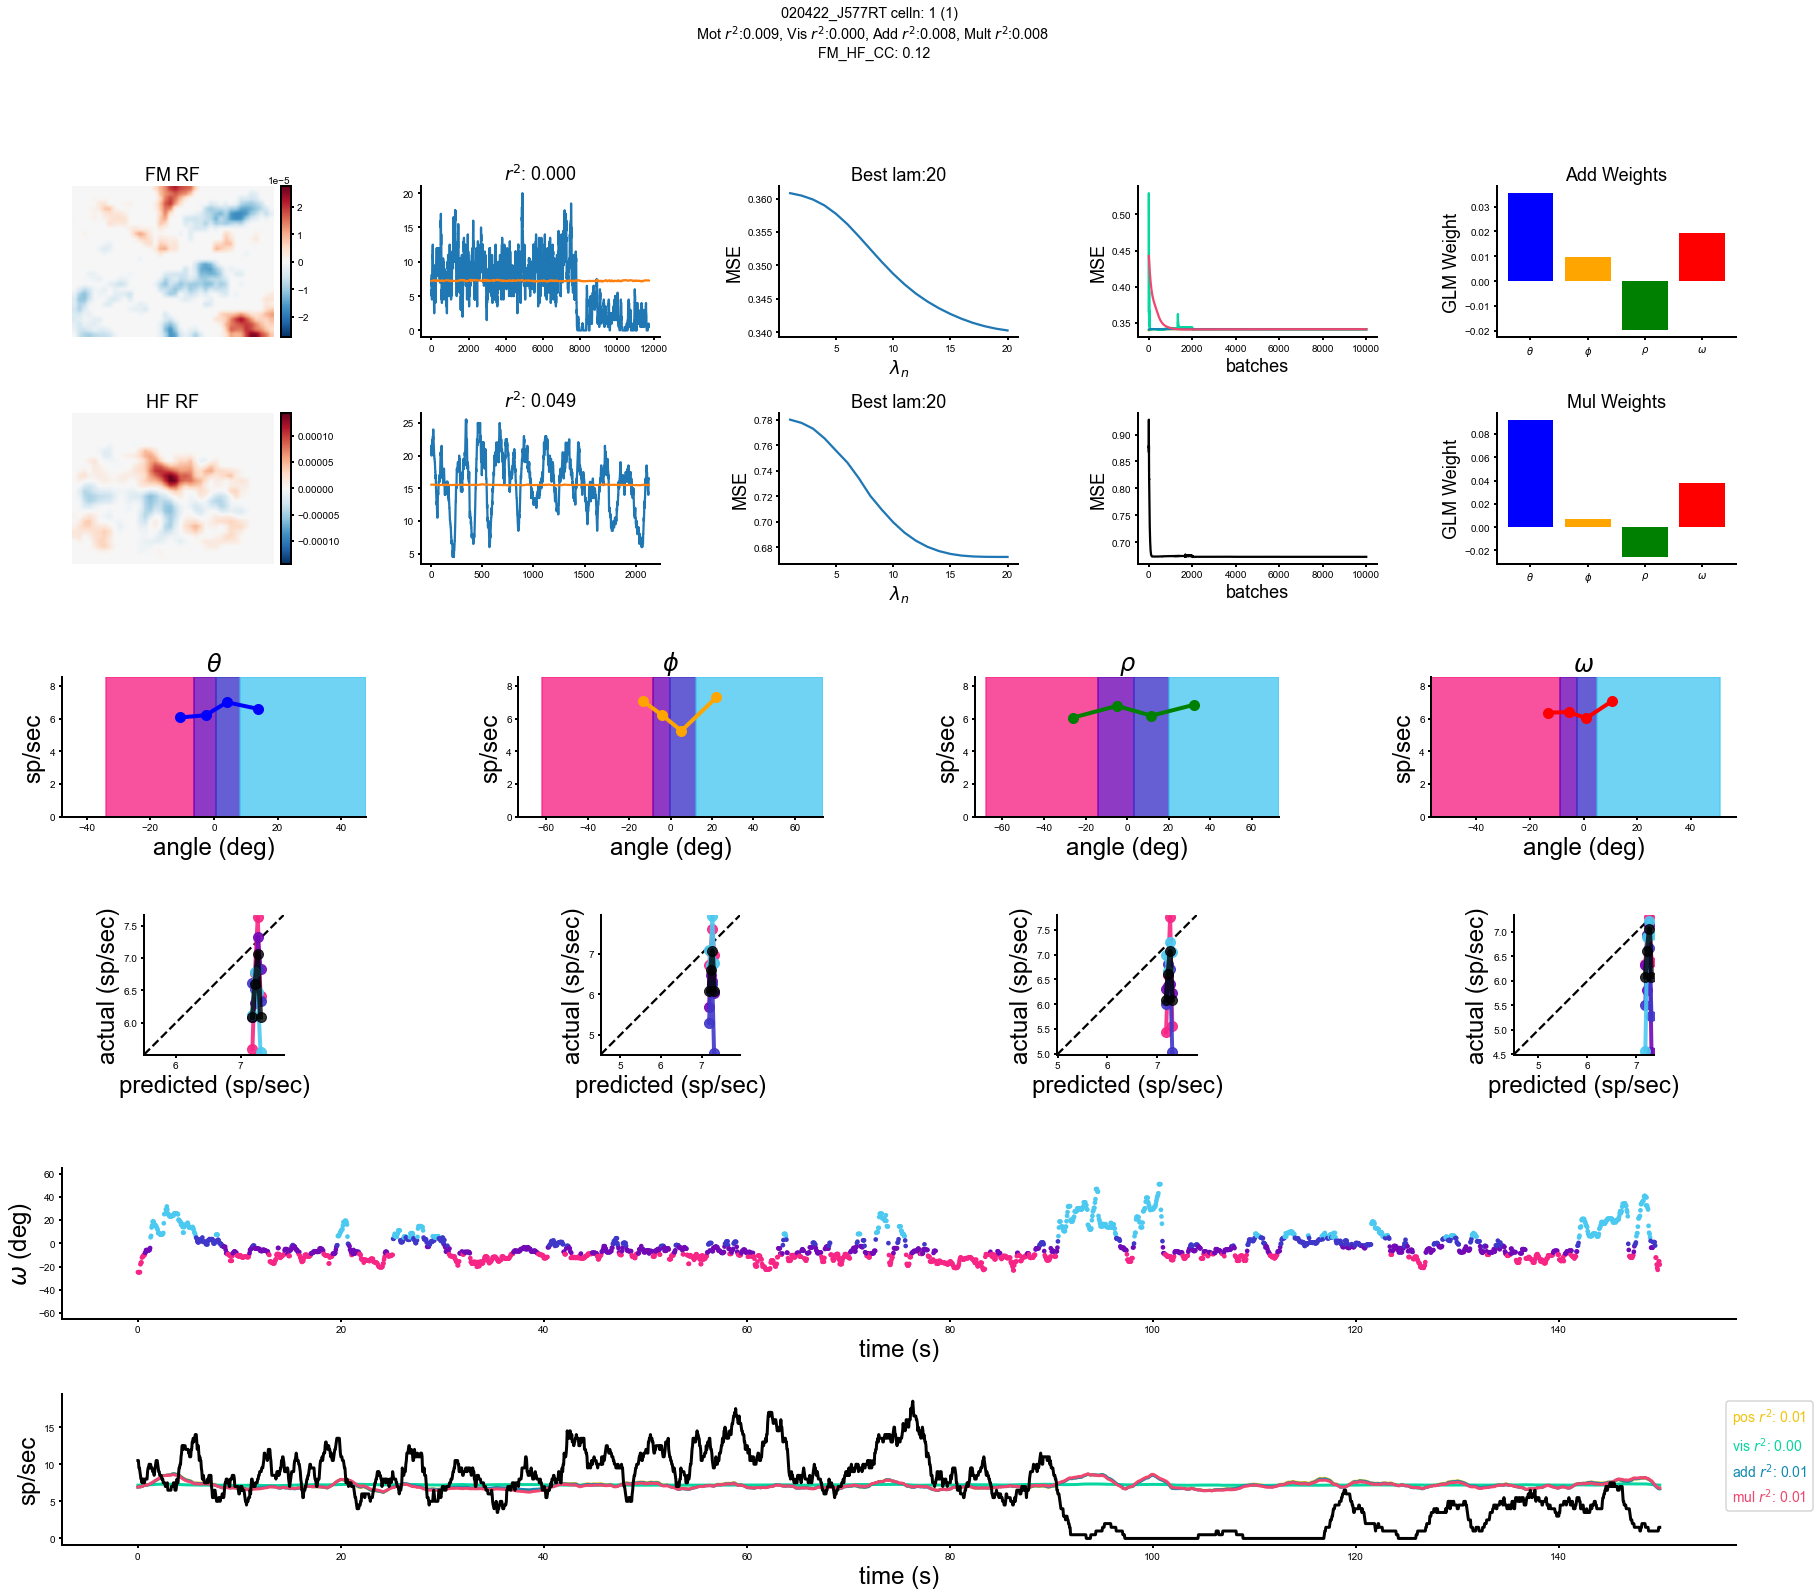

In [22]:
celln = 1
modN = 1
fontsize=24
anglim=65
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)
fig = plt.figure(constrained_layout=False, figsize=(30,25))
gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

########## Plotting FM/HF RFs ##########
gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

ax = axs0a[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')
ax.set_title('FM RF')

ax = axs0a[1]
ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['vis_r2_test'][celln]))

ax = axs0a[2]
ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

ax =axs0a[3]
for modN in range(len(mod_titles)-1):
    ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

########### Head Fixed plots ###########
ax = axs0b[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('HF RF')
ax.axis('off')

ax = axs0b[1]
ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['HF_r2_test'][celln]))

ax = axs0b[2]
ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

ax =axs0b[3]
ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

######### Position Weights ##########

w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
for modeln in range(len(titles)):
    axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
    axs0a[4].set_xticks(np.arange(0,len(titles)))
    axs0a[4].set_xticklabels(titles)
    axs0a[4].set_ylabel('GLM Weight')
    axs0a[4].set_title('Add Weights')

    axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
    axs0b[4].set_xticks(np.arange(0,len(titles)))
    axs0b[4].set_xticklabels(titles)
    axs0b[4].set_ylabel('GLM Weight')
    axs0b[4].set_title('Mul Weights')



########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#
    for m in range(len(nranges)-1):
        axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
    axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
    axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
    axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
    axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

    
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].axis('square')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    # axs1b[0,modeln].axis('equal')
    axs1b[0,modeln].set(xlim=lims, ylim=lims)
    # axs1b[0,modeln].set_ylim(bottom=0)



########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position Scatter #####
t0=300
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-t0)) # 200 seconds in #6000
dt = int(150/params['model_dt']) # All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

# celln = 18#106
# da = 0
# t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
# dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_cc'][celln]
plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,celln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
plt.show()

### Simulated RF

In [2]:
def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap='RdBu_r',vmin=-1,vmax=1, **kwargs)

In [3]:
def gabor(sz, offset, sigma=4, theta=0, Lambda=4*np.pi, psi=np.pi, gamma=1.25, nstds=3):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # # Bounding box
    # xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    # xmax = np.ceil(max(1, xmax))
    # ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    # ymax = np.ceil(max(1, ymax))
    # xmin = -xmax
    # ymin = -ymax
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    # Rotation
    x_theta =  (x-offset[0]) * np.cos(theta) + (y-offset[1]) * np.sin(theta)
    y_theta = -(x-offset[0]) * np.sin(theta) + (y-offset[1]) * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb


In [ ]:
gaborParam = {'offset':(ox,oy), 'theta':np.pi, 'sigma':2,'Lambda':5*np.pi,'psi':0,'sz':(40, 30)}
g = gabor(**gaborParam)[:-1,:-1]
plt.imshow(g)

In [18]:

# args['date_ani'] = '021522/SimRF' #
args['SimRF'] = True
params,_,_ = load_params(1,Kfold,args,file_dict={},debug=True)
params['nt_glm_lag'] = 1
params['lag_list'] = [0]
data, train_idx_list, test_idx_list = load_train_test({}, **params)

##### Set Train Test Splits #####
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data, train_idx, test_idx, params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'], params['LinMix'], params['move_features'], params['Ncells'], params['train_shifter']))
yte2 = yte.cpu().detach().numpy()

KeyError: 'name'

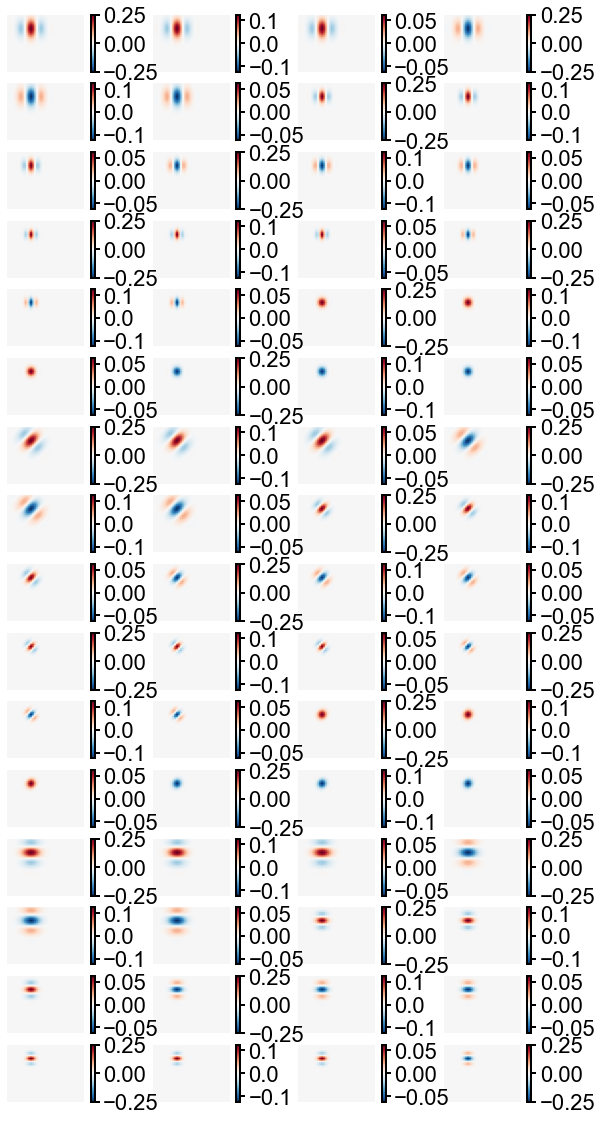

In [6]:
fig, axs = plt.subplots(16,4, figsize=(10,20))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.axis('off')
    crange = np.max(np.abs(FilterBank[n]))
    im = ax.imshow(FilterBank[n], cmap='RdBu_r',vmin=-crange,vmax=crange)
    add_colorbar(im)

In [19]:
theta = np.arange(0, np.pi, np.pi/4) # range of theta
offsetx = np.arange(-8,8,4)
offsety = np.arange(-8,8,4)
sz_list = [4,(2/3)*4,2,2]
sz_list2 = [4*np.pi,(2*np.pi/3)*4,2*np.pi,5*np.pi]
psi_list = [0,np.pi]
scales = [4,8,16]
FilterBank = []
gaborParams = []
for ox in offsetx:
    for oy in offsety:
        for th in theta:
            for (sz1,sz2) in zip(sz_list,sz_list2):
                for psi in psi_list:
                    for scale in scales:
                        gaborParam = {'offset':(ox,oy), 'theta':th,'sigma':sz1,'Lambda':sz2, 'psi':psi,'sz':(40, 30)}
                        g = gabor(**gaborParam)[:-1,:-1]
                        FilterBank.append(g/scale)
                        gaborParams.append(gaborParam)
FilterBank=np.stack(FilterBank)


output_size = FilterBank.shape[0]
input_size = 1200
bias_sim = np.random.rand(FilterBank.shape[0])
# scale_w = 8*np.ones(FilterBank.shape[0])[:,np.newaxis] #np.random.randint(8,9,FilterBank.shape[0])[:,np.newaxis] # 5,6 10 Hz average did great
# FilterBank = FilterBank/scale_w[:,:,np.newaxis]
FilterBank_flt = FilterBank.reshape(output_size,-1)
l1 = LinVisNetwork(input_size,output_size)
l1.Cell_NN[0].weight.data = torch.from_numpy((FilterBank_flt).astype(np.float32))
l1.Cell_NN[0].bias.data = torch.from_numpy(bias_sim.astype(np.float32))
FilterBank.shape

(1536, 30, 40)

In [17]:
out = l1(xtr.cpu())


Wrong Input Features. Please use tensor with 1200 Input Features


In [20]:
xtr.shape

torch.Size([21191, 6000])

In [13]:
out = l1(xtr.cpu())
pred = l1(xte.cpu())
out = np.random.poisson(out.cpu().detach().numpy())
pred = np.random.poisson(pred.cpu().detach().numpy())
lag_list = [0]

# model_vid = rolled_vid.reshape(data['model_vid_sm'].shape[0],-1)
Ncells = out.shape[-1]
model_vid = xtr.cpu().detach().numpy()
sta = (model_vid.T @ out)/np.sum(out,0,keepdims=True)
sta_im = sta.T.reshape((Ncells,len(lag_list)) + data['model_vid_sm'].shape[1:])

Kfold=0
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ioh5.save(SimRF_file,{'ytr':out,'yte':pred,'RF_actual':FilterBank,'bias_sim':bias_sim,'sta':sta})

Wrong Input Features. Please use tensor with 1200 Input Features
Wrong Input Features. Please use tensor with 1200 Input Features


AttributeError: 'int' object has no attribute 'cpu'

In [404]:
ioh5.save(SimRF_file,{'ytr':out,'yte':pred,'RF_actual':FilterBank,'bias_sim':bias_sim,'sta':sta})

(array([14., 37., 32., 36., 40., 51., 51., 66., 59., 58., 53., 69., 80.,
        72., 83., 61., 62., 63., 59., 63., 66., 57., 35., 26., 29., 18.,
        30., 19., 14., 12., 13., 14., 12., 11., 10.,  9.,  9., 12.,  7.,
         8.,  6.,  2.,  2.,  2.,  1.,  0.,  1.,  0.,  1.,  1.]),
 array([ 0.27842008,  1.19197773,  2.10553537,  3.01909301,  3.93265065,
         4.8462083 ,  5.75976594,  6.67332358,  7.58688122,  8.50043887,
         9.41399651, 10.32755415, 11.24111179, 12.15466944, 13.06822708,
        13.98178472, 14.89534236, 15.8089    , 16.72245765, 17.63601529,
        18.54957293, 19.46313057, 20.37668822, 21.29024586, 22.2038035 ,
        23.11736114, 24.03091879, 24.94447643, 25.85803407, 26.77159171,
        27.68514936, 28.598707  , 29.51226464, 30.42582228, 31.33937993,
        32.25293757, 33.16649521, 34.08005285, 34.9936105 , 35.90716814,
        36.82072578, 37.73428342, 38.64784106, 39.56139871, 40.47495635,
        41.38851399, 42.30207163, 43.21562928, 44.12918692,

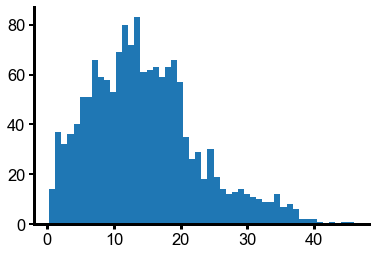

In [368]:
plt.hist(np.mean(out,axis=0)/.05,bins=50)

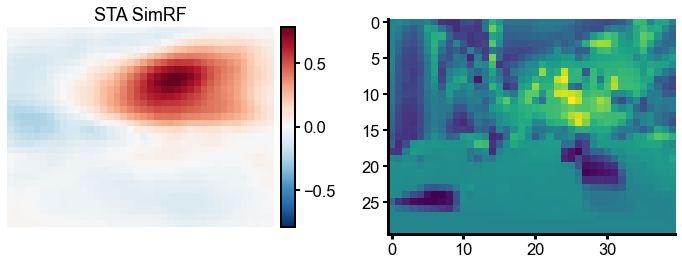

In [207]:
cell = 500
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
crange2 = np.max(np.abs(sta_im[cell]))
im2 = ax.imshow(sta_im[cell,0],'RdBu_r', vmin=-crange2, vmax=crange2)
ax.set_title('STA SimRF')
ax.axis('off')
cbar = add_colorbar(im2)

ax = axs[1]
plt.imshow(model_vid.reshape((xtr.shape[0],)+data['model_vid_sm'].shape[1:])[500])
plt.tight_layout()

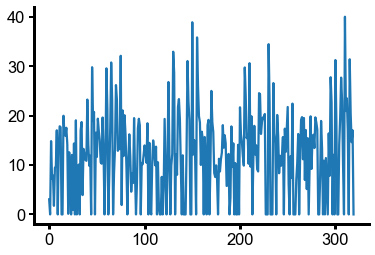

In [105]:
# Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=pred.detach().cpu().numpy())[params['bin_length']:-params['bin_length']].T
plt.plot(Sim_act_smooth[:,24])

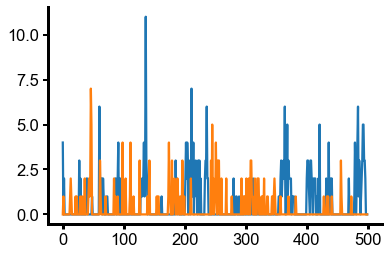

In [209]:
plt.plot(pred[:500,300])
plt.plot(yte[:500,12].cpu().detach().numpy())

In [463]:
args['free_move'] = True
args['date_ani'] = '121521/SimRF'
args['NoL1']=False
args['Nepochs'] = 10000
params,_,_ = load_params(1,Kfold,args,file_dict={},debug=True)
params['nt_glm_lag']=1
date_ani_dir = params['save_dir'].parent.parent.parent/args['date_ani']
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_SimRF_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_SimRF_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('VisNoShifter' not in path.stem)]))
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format('withL1',int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
ModelList

array([PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5')],
      dtype=object)

In [464]:
GLM_Data = ioh5.load(ModelList[0])
SimRF_data = ioh5.load(SimRF_file)
RF_Sim = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0], params['nt_glm_lag'],)+(30,40))
Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(Sim_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(512,)

In [645]:
simfr_mean = np.mean(SimRF_data['yte'],axis=0)/params['model_dt']
simfr_low = Sim_r2[2::3] #Sim_r2[((simfr_mean<5))]
simfr_med = Sim_r2[1::3] #Sim_r2[((simfr_mean>5) & (simfr_mean<10))]
simfr_high = Sim_r2[0::3] #Sim_r2[((simfr_mean>10))]

np.nanmean(simfr_low),np.nanmean(simfr_med),np.nanmean(simfr_high),
mean_fr_low = np.nanmean(simfr_mean[2::3])
mean_fr_med = np.nanmean(simfr_mean[1::3])
mean_fr_high = np.nanmean(simfr_mean[0::3])

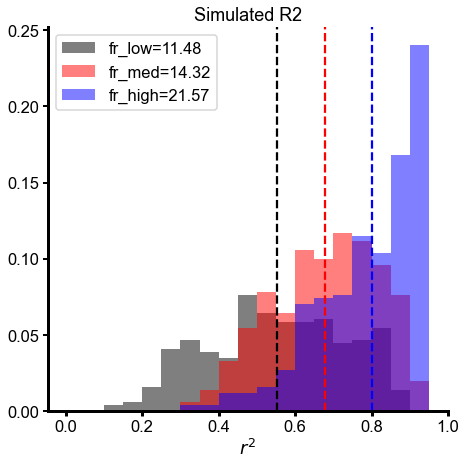

In [648]:
fig, ax0 = plt.subplots(1,1,figsize=(7,7))
ax = ax0
count,edges = np.histogram(simfr_low,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_low),color='k',width=hbins, alpha=.5,label='fr_low={:.02f}'.format(mean_fr_low))
ax.axvline(x=np.nanmean(simfr_low),c='k',ls='--')

count,edges = np.histogram(simfr_med,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_med),color='r',width=hbins, alpha=.5,label='fr_med={:.02f}'.format(mean_fr_med))
ax.axvline(x=np.nanmean(simfr_med),c='r',ls='--')

count,edges = np.histogram(simfr_high,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_high),color='b',width=hbins, alpha=.5,label='fr_high={:.02f}'.format(mean_fr_high))
ax.axvline(x=np.nanmean(simfr_high),c='b',ls='--')

ax.set_xticks(np.arange(0,1.2,.2))
ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
ax.set_title('Simulated R2')
ax.set_xlabel(r'$r^2$')
ax.legend()
plt.tight_layout()

fig.savefig(paper_fig_dir/'sim_RF_hist.png', facecolor='white', transparent=True, bbox_inches='tight')


In [466]:
save_pdf = True
hbins = .05
pdf_name = paper_fig_dir/ ('SimulatedRF_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig, ax0 = plt.subplots(1,1,figsize=(7,7))
    ax = ax0
    count,edges = np.histogram(Sim_r2,bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(Sim_r2),color='k',width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('Simulated R2')
    ax.set_xlabel(r'$r^2$')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

pbar = tqdm(range(Sim_r2.shape[0]))
# pbar = [0,1,2,3]
for cell in pbar:
    fig1 = plt.figure(constrained_layout=False, figsize=(15,10))
    gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.2,hspace=.3)

    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,:],wspace=.3,hspace=.05)
    axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(1) for m in range(3)]).reshape(1,3)
    da = 0
    ax = axs1[0,0]
    crange2 = np.max(np.abs(RF_Sim[cell]))
    im2 = ax.imshow(RF_Sim[cell,0],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Fit SimRF')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ax = axs1[0, 1]
    crange2 = np.max(np.abs(SimRF_data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Actual SimRF')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ax = axs1[0, 2]
    diff = SimRF_data['RF_actual'][cell] - RF_Sim[cell, 0]
    crange2 = np.max(np.abs(diff))
    im2 = ax.imshow(diff, 'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Difference')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ##### Predictions #####
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,:-1],wspace=.2,hspace=.05)
    axs2 = fig1.add_subplot(gs02[0])
    ax = axs2
    ax.plot(Sim_act_smooth[cell],label='Sim Actual')
    ax.plot(Sim_smooth[:,cell],label='Pred')
    ax.legend()
    ax.set_title('r2:{:.02f}'.format(Sim_r2[cell]))
    plt.suptitle('celln: {}'.format(cell))

    # plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()

# fig1.savefig(paper_fig_dir/'Simulated_RF_Cell{}.png'.format(cell), facecolor='white', transparent=True, bbox_inches='tight')


  0%|          | 0/1536 [00:00<?, ?it/s]

### Tuning Histograms

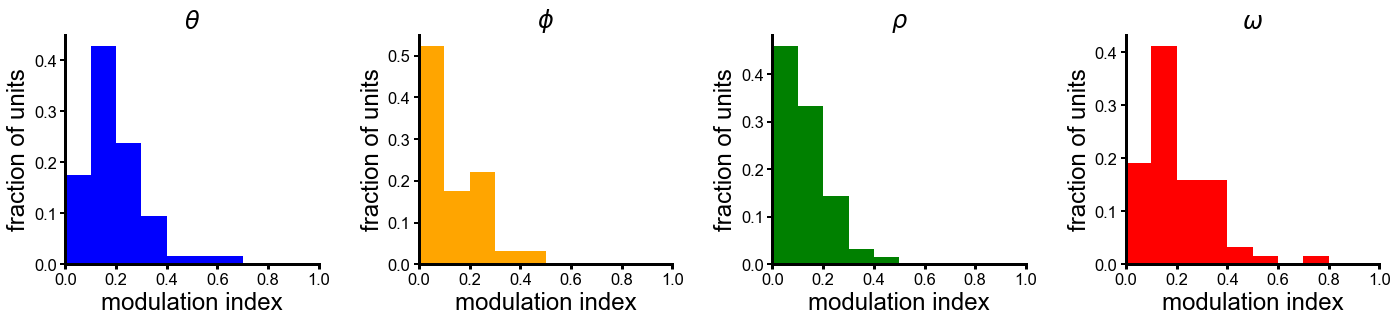

In [33]:
clrs = ['blue','orange','green','red']
fontsize=24
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title(r'$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
    ax[modeln].set_xlabel('modulation index', fontsize=fontsize)
    ax[modeln].set_ylabel('fraction of units', fontsize=fontsize)
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()
# fig.savefig(fig_dir/'Modulation_hist.pdf',facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
celln = 126
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(25,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=25, lw=7,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(r'$\{}$'.format(titles[modeln]),fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()
fig.savefig(fig_dir/'Turning_Curve_cell{}.pdf'.format(celln),facecolor='white', transparent=True, bbox_inches='tight')

### Raster/WorldCam/EyeCam/IMU Example

In [8]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

# data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

# ##### Set Train Test Splits #####
# Kfold = 0
# train_idx = train_idx_list[Kfold]
# test_idx = test_idx_list[Kfold]
# data = load_Kfold_data(data,train_idx,test_idx,params)

data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [9]:
date_ani = '070921/J553RT'
stim_type = 'fm1'
fmimu_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*imu.nc'))[0]
eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*REYE.nc'))[0]
world_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*world.nc'))[0]
ephys_file = params['save_dir']/'RawEphysData.h5'

ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']

imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
eyeT = eye_data.timestamps  - ephys_data['t0'].iloc[0]

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

world_data = xr.open_dataset(file_dict['world'])
world_vid_raw = np.uint8(world_data['WORLD_video'])
worldT = world_data.timestamps.copy()
worldT = worldT - ephys_data['t0'].iloc[0]

if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
if worldT[0]<-600:
    worldT = worldT + 8*60*60
accT2 = accT.sample.data - ephys_data['t0'].iloc[0]


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/array.py

In [ ]:
eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).rglob('*REYEdeinter.avi'))[0]

cap = cv2.VideoCapture(eye_file.as_posix())
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = int(cap.get(cv2.CAP_PROP_FPS)) # float `fps`
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # float `total_frame_in_the_video` (should not be applicable for camera)
sf=2
eye_vid = np.zeros((int(total_frames),140, 175))
for t in tqdm(range(total_frames)):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray,(int(width//sf),int(height//sf)))
    eye_vid[t] = gray[100:,75:250]

cap.release()

  0%|          | 0/147790 [00:00<?, ?it/s]

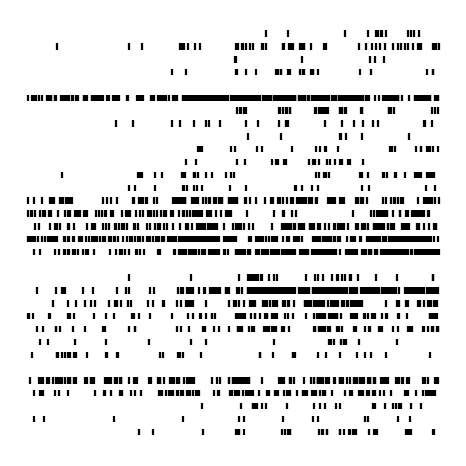

In [91]:
fig, axs = plt.subplots(figsize=(7,7))
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])
ax = axs
ax.eventplot(cell_spikes[:32],color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
ax.axis('off')
plt.tight_layout()
fig.savefig(paper_fig_dir/'SpikeRaster_a.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [12]:

dT = 5
Tmin = 1497
Tmax = Tmin + 10
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

/tmp/ipykernel_260644/3608464905.py:52: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


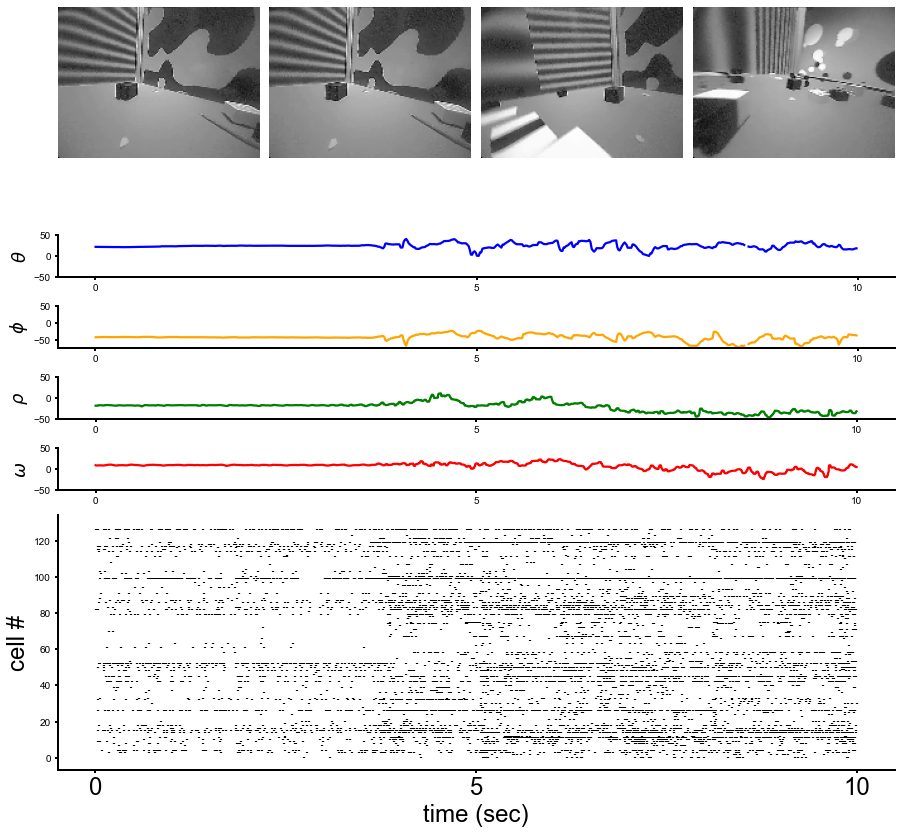

In [222]:
fontsize=24
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']

dT = 5
Tmin = 1497
Tmax = Tmin + 10
dT_all = Tmax-Tmin
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])

fig = plt.figure(constrained_layout=False, figsize=(15,15))
gs0 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig,wspace=.1,hspace=.1)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[:1,:],wspace=.05,hspace=.05)
gs01 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[1,0],wspace=.5,hspace=.7)
gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2,0],wspace=.5,hspace=.7)
axs1a = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(gs00.ncols)])
axs1b = np.array([fig.add_subplot(gs01[n,m]) for n in range(4) for m in range(1)])
axs1c = np.array([fig.add_subplot(gs02[0,0])])

skipT = [0,2,4,6]
for n,ax in enumerate(axs1a):
    skipT2 = np.nanargmin(np.abs(worldT-skipT[n]))
    ax.imshow(world_vid_raw[worldTmin+skipT2],cmap='gray')
    ax.axis('off')

ax = axs1b[0]
ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax],c=move_clrs[0])
ax.set_ylabel(titles[0])
ax = axs1b[1]
ax.plot(eyeT[eyeTmin:eyeTmax],phi[eyeTmin:eyeTmax],c=move_clrs[1])
ax.set_ylabel(titles[1])
ax = axs1b[2]
ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax],c=move_clrs[2])
ax.set_ylabel(titles[2])
ax = axs1b[3]
ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax],c=move_clrs[3])
ax.set_ylabel(titles[3])

for ax, modeln in zip(axs1b,range(len(titles))):
    ax.set_yticks([-50,0,50])
    ax.set_xticks(np.arange(Tmin,Tmax+1,5))
    ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5))

ax = axs1c[0]
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)

plt.show()
# fig.savefig(paper_fig_dir/'SpikeRaster.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [36]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))

probe = image.imread(list(paper_fig_dir.glob('*probe.png'))[0])


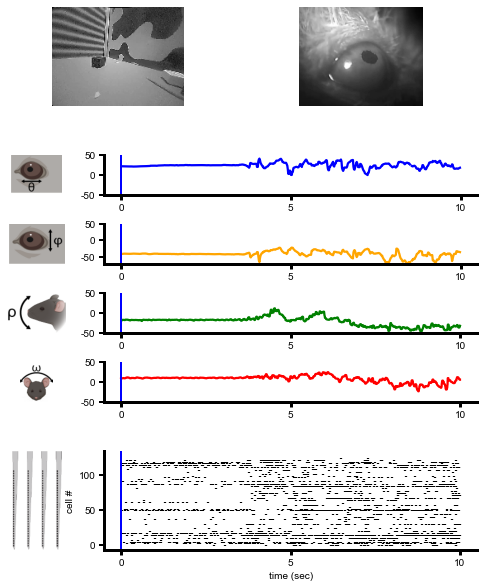

In [39]:
dT = 5
Tmin = 1497
Tmax = Tmin + 10
dT_all = Tmax-Tmin
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])


wt=0
fontsize=10
t=worldTmin + wt
tt = worldT[t].data
eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
cell_t = np.nanargmin(np.abs(cellT-(tt)))

fig = plt.figure(constrained_layout=False, figsize=(8.5,10))
gs0 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig,wspace=.1,hspace=.5)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[:1,:],wspace=.05,hspace=.05)
gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1:3,0],wspace=.5,hspace=.7)
gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0[3,0],wspace=.5,hspace=.7)
axs1a = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(gs00.ncols)])
axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(4) for m in range(1)])
axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(4) for m in range(1)])
axs1cc = np.array([fig.add_subplot(gs02[0,0])])
axs1c = np.array([fig.add_subplot(gs02[0,1:])])


ax = axs1a[0]
ax.imshow(world_vid_raw[t],cmap='gray')
ax.axis('off')
ax = axs1a[1]
ax.imshow(eye_vid[t],cmap='gray')
ax.axis('off')

ax = axs1bb[0]
ax.imshow(icons[0])
ax.axis('off')
ax = axs1b[0]
ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax],c=move_clrs[0])
ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

ax = axs1bb[1]
ax.imshow(icons[1])
ax.axis('off')
ax = axs1b[1]
ax.plot(eyeT[eyeTmin:eyeTmax],phi[eyeTmin:eyeTmax],c=move_clrs[1])
ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

ax = axs1bb[2]
ax.imshow(icons[2])
ax.axis('off')
ax = axs1b[2]
ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax],c=move_clrs[2])
ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

ax = axs1bb[3]
ax.imshow(icons[3])
ax.axis('off')
ax = axs1b[3]
ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax],c=move_clrs[3])
ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

for ax, modeln in zip(axs1b,range(len(titles))):
    ax.set_yticks([-50,0,50])
    ax.set_yticklabels([-50,0,50], fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin,Tmax+1,5))
    ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)


ax = axs1cc[0]
ax.imshow(probe)
ax.axis('off')
ax = axs1c[0]
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
ax.set_yticks([0,50,100])
ax.set_yticklabels([0,50,100], fontsize=fontsize)

ax.axvline(x=cellT[cell_t],c='b',lw=2)

In [43]:
@ray.remote
def make_plt_im(wt, worldTmin,worldTmax,worldT,eyeTmin,eyeTmax,eyeT,eye_vid,accT,moveTmin,moveTmax,world_vid_raw,th,phi,gpitch,groll,cell_spikes, Tmin,Tmax,dT,dT_all, pbar: ActorHandle,):  #

    t=worldTmin + wt
    tt = worldT[t].data
    eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
    acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
    cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
    cell_t = np.nanargmin(np.abs(cellT-(tt)))
    
    fig = plt.figure(constrained_layout=False, figsize=(8.5,10))
    gs0 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig,wspace=.1,hspace=.5)
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[:1,:],wspace=.05,hspace=.05)
    gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1:3,0],wspace=.5,hspace=.7)
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0[3,0],wspace=.5,hspace=.7)
    axs1a = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(gs00.ncols)])
    axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(4) for m in range(1)])
    axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(4) for m in range(1)])
    axs1cc = np.array([fig.add_subplot(gs02[0,0])])
    axs1c = np.array([fig.add_subplot(gs02[0,1:])])


    ax = axs1a[0]
    ax.imshow(world_vid_raw[t],cmap='gray')
    ax.axis('off')
    ax = axs1a[1]
    ax.imshow(eye_vid[eye_interp_t],cmap='gray')
    ax.axis('off')

    ax = axs1bb[0]
    ax.imshow(icons[0])
    ax.axis('off')
    ax = axs1b[0]
    ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax],c=move_clrs[0])
    ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ax = axs1bb[1]
    ax.imshow(icons[1])
    ax.axis('off')
    ax = axs1b[1]
    ax.plot(eyeT[eyeTmin:eyeTmax],phi[eyeTmin:eyeTmax],c=move_clrs[1])
    ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ax = axs1bb[2]
    ax.imshow(icons[2])
    ax.axis('off')
    ax = axs1b[2]
    ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax],c=move_clrs[2])
    ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

    ax = axs1bb[3]
    ax.imshow(icons[3])
    ax.axis('off')
    ax = axs1b[3]
    ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax],c=move_clrs[3])
    ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

    for ax, modeln in zip(axs1b,range(len(titles))):
        ax.set_yticks([-50,0,50])
        ax.set_yticklabels([-50,0,50], fontsize=fontsize)
        ax.set_xticks(np.arange(Tmin,Tmax+1,5))
        ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)


    ax = axs1cc[0]
    ax.imshow(probe)
    ax.axis('off')
    ax = axs1c[0]
    ax.eventplot(cell_spikes,color='k',linelengths=.5)
    ax.set_xlabel('time (sec)',fontsize=fontsize)
    ax.set_ylabel('cell #',fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
    ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels([0,50,100], fontsize=fontsize)

    ax.axvline(x=cellT[cell_t],c='b',lw=2)
    plt.show()
    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [46]:
mpl.use('agg')

dT = 5
Tmin = 1497
Tmax = Tmin + 10
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(worldTmax-worldTmin)
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
worldT_r = ray.put(worldT)
eyeT_r = ray.put(eyeT)
accT_r = ray.put(accT)
world_vid_raw_r = ray.put(world_vid_raw)
th_r = ray.put(th)
phi_r = ray.put(phi)
gpitch_r = ray.put(gpitch)
groll_r = ray.put(groll)
cell_spikes_r = ray.put(cell_spikes)
eye_vid_r = ray.put(eye_vid)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t,worldTmin,worldTmax,worldT_r,eyeTmin,eyeTmax,eyeT_r,eye_vid_r,accT_r,moveTmin,moveTmax,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r, Tmin,Tmax,dT,dT_all, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = date_ani2[da] + '_SVid1.mp4'


vid_name = paper_fig_dir / aniname
FPS = 60
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb,worldT_r,eyeT_r,accT_r,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r,eye_vid_r
gc.collect()


In [44]:
nn = 0
for n in tqdm(range(10000)):
    nn= n+1

  0%|          | 0/10000 [00:00<?, ?it/s]

### Position Only

In [ ]:
celln = 101
bin_length=40
Nepochs = 5000
fontsize = 24
for Kfold in range(3):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold))
    GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))
    GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))

    fig,ax = plt.subplots(figsize=(20,5))
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2,label='Actual')
    ax.plot(np.arange(len(pred_smooth_Mot))*params['model_dt'],pred_smooth_Mot,'r', lw=2,label='Mot')
    ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'b', lw=2,label='Vis')
    ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'m', lw=2,label='Add')
    ax.plot(np.arange(len(pred_smooth_Mul))*params['model_dt'],pred_smooth_Mul,'g', lw=2,label='Mul')
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
    ax.set_xlabel('Time (s)',fontsize=fontsize)
    ax.set_ylabel('Spike Rate',fontsize=fontsize)
    r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
    r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
    r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
    r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
    ax.set_title('Kfold:{:02d}, Mot:{:.03}, Vis:{:.03}, Add:{:.03}, Mul:{:.03}'.format(Kfold, r2_Mot,r2_Vis,r2_Add,r2_Mul))
    fig.savefig(fig_dir/'ExamplePredFR_celln{}_Kfold{:02d}.png'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
Kfold = 2
Nepochs=5000
bin_length = 40
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 5000, Kfold))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))


In [ ]:

celln = 101
t = 1200
dt = 2000
fontsize=24
fig,ax = plt.subplots(figsize=(15,5))
sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2

ax.plot(np.arange(len(sp_smooth[t:t+dt]))*params['model_dt'],sp_smooth[t:t+dt], 'k', lw=5,label='Actual', zorder=0)
ax.plot(np.arange(len(pred_smooth_Mot[t:t+dt]))*params['model_dt'],pred_smooth_Mot[t:t+dt],'r', lw=5,label='Pos: $r^2$={:.02f}'.format(r2_Mot), zorder=4)
ax.plot(np.arange(len(pred_smooth_Vis[t:t+dt]))*params['model_dt'],pred_smooth_Vis[t:t+dt],'b', lw=5,label='Vis: $r^2$={:.02f}'.format(r2_Vis), zorder=3)
ax.plot(np.arange(len(pred_smooth_Add[t:t+dt]))*params['model_dt'],pred_smooth_Add[t:t+dt],'m', lw=5,label='Add: $r^2$={:.02f}'.format(r2_Add), zorder=2)
ax.plot(np.arange(len(pred_smooth_Mul[t:t+dt]))*params['model_dt'],pred_smooth_Mul[t:t+dt],'g', lw=5,label='Mul: $r^2$={:.02f}'.format(r2_Mul), zorder=1)
ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True, bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

fig.savefig(fig_dir/'Mul_ExamplePredFR_celln{}_Kfold{:02d}.pdf'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')

### All FM and HF RFs

In [309]:
## Max/std of each rf signal to noise threshold out bad rfs. 

In [189]:
mean_HF_fr = np.hstack([All_data[date_ani2[da]]['HF_meanfr'] for da in range(len(dates_all))])
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_cc']  for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
vals_HF = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
r2_FMHF = np.stack((vals_Vis,vals_HF))
FM_RF_all = np.concatenate([All_data[date_ani2[da]]['vis_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
HF_RF_all = np.concatenate([All_data[date_ani2[da]]['HF_rf_all'][:,2]  for da in range(len(dates_all))],axis=0)
RF_all_stack = np.concatenate((FM_RF_all,HF_RF_all),axis=-2)[:,np.newaxis]
RF_all_stack.shape

(268, 1, 60, 40)

In [180]:
np.sum(vals_FMHF>.3)/vals_FMHF.shape[0]

0.13059701492537312

Text(0, 0.5, '$r^2_{FM}$')

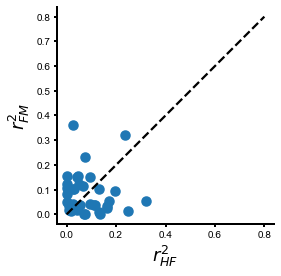

In [181]:
plt.scatter(vals_HF[vals_FMHF>.3],vals_Vis[vals_FMHF>.3])
plt.plot(np.linspace(0,.8,100),np.linspace(0,.8,100),'k--')
plt.axis('square')
# plt.plot(pts, pts, 'k--')
plt.xlabel(r'$r^2_{HF}$')
plt.ylabel(r'$r^2_{FM}$')


In [190]:
sorted_r2 = np.argsort(vals_FMHF)[::-1] ##### Sorted indecies for R2
hf_inds = np.arange(mean_HF_fr.shape[0])[mean_HF_fr<1]
sorted_r2 = np.delete(sorted_r2,[np.argwhere(sorted_r2 == hf_inds[n])[0,0] for n in range(len(hf_inds))])
FM_RF_all_snr=FM_RF_all.copy()
HF_RF_all_snr=HF_RF_all.copy()
FM_RF_all_snr[(np.abs(FM_RF_all_snr)<1e-6)] = np.nan
HF_RF_all_snr[(np.abs(HF_RF_all_snr)<1e-6)] = np.nan
snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))

/tmp/ipykernel_467441/4060230790.py:8: RuntimeWarning: All-NaN slice encountered
  snr_FM = np.nanmax(np.abs(FM_RF_all_snr),axis=(-2,-1))/np.nanstd(FM_RF_all_snr,axis=(-2,-1))
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_467441/4060230790.py:9: RuntimeWarning: All-NaN slice encountered
  snr_HF = np.nanmax(np.abs(HF_RF_all_snr),axis=(-2,-1))/np.nanstd(HF_RF_all_snr,axis=(-2,-1))


(array([0.09889657, 0.13186223, 0.06593111, 0.09889667, 0.06593111,
        0.16482778, 0.32965557, 0.36262113, 0.4615178 , 0.4615178 ,
        0.26372446, 0.32965557, 0.65931114, 0.29669001, 0.49448335,
        0.39558668, 0.32965491, 0.32965623, 0.3626204 , 0.23075936,
        0.29668942, 0.36262185, 0.23075844, 0.19779374, 0.16482746,
        0.16482811, 0.19779295, 0.06593125, 0.        , 0.09889687,
        0.06593098, 0.06593098, 0.09889687, 0.        , 0.09889687,
        0.06593098, 0.03296562, 0.        , 0.03296562, 0.06593098,
        0.03296562, 0.        , 0.        , 0.        , 0.03296562,
        0.        , 0.03296562, 0.        , 0.        , 0.03296549]),
 array([1.9769119, 2.09634  , 2.2157679, 2.3351958, 2.4546237, 2.5740516,
        2.6934795, 2.8129075, 2.9323354, 3.0517633, 3.1711912, 3.2906191,
        3.410047 , 3.529475 , 3.648903 , 3.7683308, 3.8877587, 4.007187 ,
        4.1266146, 4.2460427, 4.3654704, 4.4848986, 4.6043262, 4.7237544,
        4.843182 , 4.9

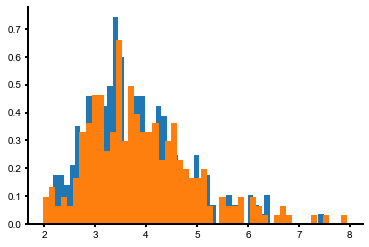

In [183]:
plt.hist(snr_FM,bins=50,density=True)
plt.hist(snr_HF,bins=50,density=True)

# plt.hist(snr_HF>4,bins=50,density=True)

In [191]:
pdf_name = paper_fig_dir/ ('FMHF_RF.pdf')
pdf = PdfPages(pdf_name)
for cell in tqdm(sorted_r2):
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    ax = axs[0]
    crange = np.max(np.abs(FM_RF_all[cell]))
    im = ax.imshow(FM_RF_all[cell],'RdBu_r',vmin=-crange,vmax=crange)
    # ax.set_title('FM, NE: {:.3f}, snr: {:.3f}'.format(FM_noise[cell],snr_FM[cell]))
    cbar = add_colorbar(im)
    plt.suptitle('celln: {}, FM:{:.3f}, HF:{:.3f}, cc:{:.3f}'.format(cell, vals_Vis[cell],vals_HF[cell],vals_FMHF[cell]))

    ax = axs[1]
    crange = np.max(np.abs(HF_RF_all[cell]))
    im = ax.imshow(HF_RF_all[cell],'RdBu_r',vmin=-crange,vmax=crange)
    # ax.set_title('HF,  NE: {:.3f},  snr: {:.3f}'.format(HF_noise[cell],snr_HF[cell]))
    cbar = add_colorbar(im)

    for ax in axs.flat:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.spines[axis].set_visible(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    pdf.savefig()
    plt.close()
pdf.close()


  0%|          | 0/229 [00:00<?, ?it/s]

In [825]:
np.sum(vals_FMHF[sorted_r2]<0),np.sum(vals_FMHF[sorted_r2]>0)

(48, 101)

In [982]:
from skimage.metrics import structural_similarity as ssim


0.9999493617602075

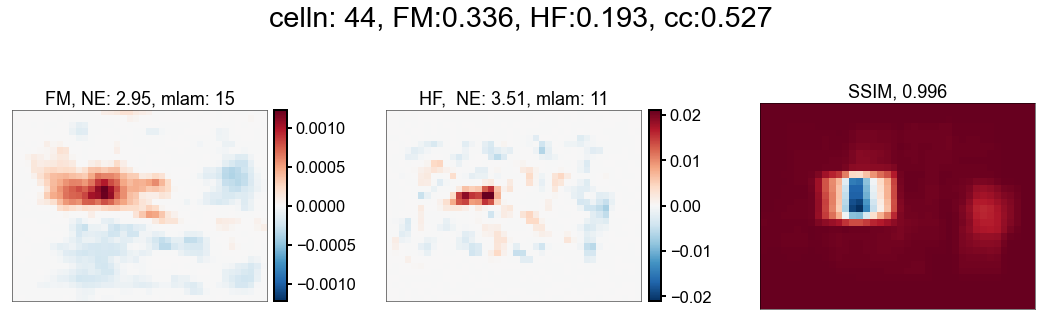

In [1067]:
cell = 44
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
crange = np.max(np.abs(FM_RF_all[cell]))
im = ax.imshow(FM_RF_all[cell],'RdBu_r',vmin=-crange,vmax=crange)
ax.set_title('FM, NE: {:.3}, mlam: {}'.format(FM_noise[cell],mlam_FM[cell]))
cbar = add_colorbar(im)
plt.suptitle('celln: {}, FM:{:.3f}, HF:{:.3f}, cc:{:.3f}'.format(cell, vals_Vis[cell],vals_HF[cell],vals_FMHF[cell]))

ax = axs[1]
crange = np.max(np.abs(HF_RF_all[cell]))
im = ax.imshow(HF_RF_all[cell],'RdBu_r',vmin=-crange,vmax=crange)
ax.set_title('HF,  NE: {:.3}, mlam: {}'.format(HF_noise[cell],mlam_HF[cell]))
cbar = add_colorbar(im)

ax = axs[2]
f,grad,ssim_img = ssim(FM_RF_all[cell],HF_RF_all[cell],gradient=True,full=True)
# crange = np.max(np.abs(ssim_img))
im = ax.imshow(ssim_img,'RdBu_r')#,vmin=-crange,vmax=crange)
ax.set_title('SSIM, {:.3}'.format(f))
# cbar = add_colorbar(im)


for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [185]:
FM_noise=[]
HF_noise=[]
for cell in range(FM_RF_all.shape[0]):
    img1=FM_RF_all[cell]/np.max(np.abs(FM_RF_all[cell]))
    img2=HF_RF_all[cell]/np.max(np.abs(HF_RF_all[cell]))
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # np.mean((img1-img2)**2)
    FM_noise.append(estimate_noise(img1))
    HF_noise.append(estimate_noise(img2))
FM_noise=np.array(FM_noise)
HF_noise=np.array(HF_noise)

NameError: name 'estimate_noise' is not defined

In [1041]:
from scipy.signal import convolve2d
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

  sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
  sigma = sigma * np.sqrt(0.5 * np.pi) / (6 * (W-2) * (H-2))

  return sigma

In [ ]:
plt.hist(FM_noise,bins=50)
plt.hist(HF_noise,bins=50)

In [1062]:
np.sum((FM_noise<5)&(HF_noise<5))

121